In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.chartSparseAnalysis import ChartSparseUtil
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

In [3]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = False)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [5]:
denseModel = "Dense Model"
denseControlModel = "Dense Control Model"
sparseModel = "Sparse Model"

In [146]:
results = experiment.train_models(
    models = {
        "Sparse Model": modelSetups._get_sparse_model,
        "Dense Model": modelSetups._get_dense_model,
        "Dense Control Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = 3,  
    model_params = {"l1": (200, 15), "l2": (250, None), "l3": (200, None)},
    n_epochs=150,
)

In [ ]:
activations = {}
with torch.no_grad():
    for modelName, model in results.items():
        op, activations[modelName] = model.forward(X_val, return_acts = True)
layers = list(activations['Sparse Model'].keys())

In [8]:
for layer in layers:
    print(f"--- {layer} ---")
    for model_name, acts in activations.items():
        a = acts[layer]
        print(f"{model_name:7s} mean={a.mean():.4f}, std={a.std():.4f}, sparsity={(a==0).float().mean():.4f}")

--- l1 ---
Sparse Model mean=0.0764, std=0.2776, sparsity=0.9250
Dense Model mean=0.1850, std=0.3023, sparsity=0.0000
Dense Control Model mean=0.2468, std=0.3365, sparsity=0.0000
--- l2 ---
Sparse Model mean=0.2349, std=0.4937, sparsity=0.0000
Dense Model mean=0.0484, std=0.5809, sparsity=0.0000
Dense Control Model mean=0.0830, std=1.2791, sparsity=0.0000
--- l3 ---
Sparse Model mean=1.7919, std=2.6886, sparsity=0.0000
Dense Model mean=0.8557, std=1.6584, sparsity=0.0000
Dense Control Model mean=1.4088, std=4.3909, sparsity=0.0000
--- out ---
Sparse Model mean=17.3878, std=22.2747, sparsity=0.0000
Dense Model mean=5.2239, std=5.7692, sparsity=0.0000
Dense Control Model mean=7.5826, std=13.4839, sparsity=0.0000


In [ ]:
def cosine_similarity_per_sample(a, b):
    return F.cosine_similarity(a.flatten(start_dim=1), b.flatten(start_dim=1)).mean()

for layer in layers:
    sim = cosine_similarity_per_sample(activations[denseModel][layer], activations[sparseModel][layer])
    print(f"{layer:10s}: cosine similarity between dense and sparse = {sim:.4f}")
    sim = cosine_similarity_per_sample(activations[denseModel][layer], activations[denseControlModel][layer])
    print(f"{layer:10s}: cosine similarity between dense and control = {sim:.4f}")

l1        : cosine similarity between dense and sparse = 0.1096
l1        : cosine similarity between dense and control = 0.2947
l2        : cosine similarity between dense and sparse = 0.0297
l2        : cosine similarity between dense and control = -0.0275
l3        : cosine similarity between dense and sparse = 0.2704
l3        : cosine similarity between dense and control = 0.1585
out       : cosine similarity between dense and sparse = 0.9944
out       : cosine similarity between dense and control = 0.9753


In [10]:
def normalize_activations(a, eps=1e-8):
    return (a - a.mean()) / (a.std() + eps)

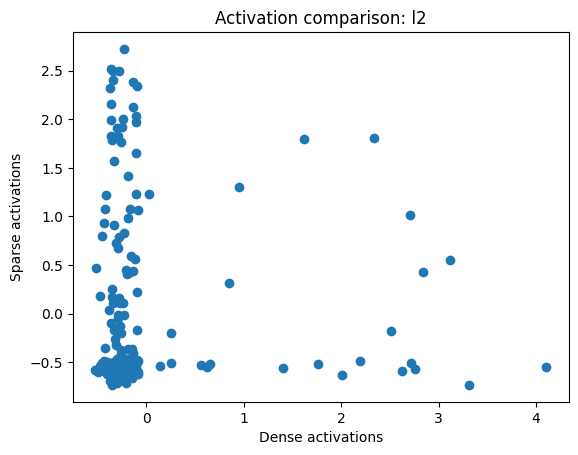

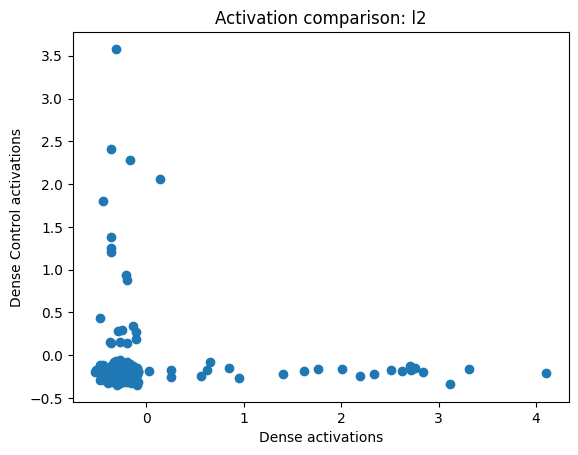

In [ ]:
layer = layers[1]
dense_act = activations[denseModel][layer]
dense_control_act = activations[denseControlModel][layer]
sparse_act = activations[sparseModel][layer]

dense_act = normalize_activations(dense_act)
dense_control_act = normalize_activations(dense_control_act)
sparse_act = normalize_activations(sparse_act)

plt.scatter(dense_act[0].numpy(), sparse_act[0].numpy())
plt.xlabel("Dense activations")
plt.ylabel("Sparse activations")
plt.title(f"Activation comparison: {layer}")
plt.show()

plt.scatter(dense_act[0].numpy(), dense_control_act[0].numpy())
plt.xlabel("Dense activations")
plt.ylabel("Dense Control activations")
plt.title(f"Activation comparison: {layer}")
plt.show()

In [4]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = False)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [5]:
layers = 3
model_params_all = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}
model_params_first = {"l1": (200, 10), "l2": (200, None), "l3": (200, None)}
model_params_second = {"l1": (200, None), "l2": (200, 10), "l3": (200, None)}
model_params_third = {"l1": (200, None), "l2": (200, None), "l3": (200, 10)}
model_params_first_second = {"l1": (200, 10), "l2": (200, 10), "l3": (200, None)}
model_params_first_third = {"l1": (200, 10), "l2": (200, None), "l3": (200, 10)}
model_params_second_third = {"l1": (200, None), "l2": (200, 10), "l3": (200, 10)}

In [21]:
model_types = {"Complete Sparse model": model_params_all, 
               "1st L Sparse": model_params_first, 
               "2nd L Sparse": model_params_second,
               "3rd L Sparse": model_params_third,
               "1st and 2nd L Sparse": model_params_first_second,
               "1st and 3rd L Sparse": model_params_first_third,
               "2nd and 3rd L Sparse": model_params_second_third
            }
def get_models(modelTypes = model_types, completeModel = "Complete Sparse model"):

    sparseResults, trainActivations, testActivations = experiment.train_models(
        models = 
        {
            "Control Model": modelSetups._get_control_model,
            "Dense Model": modelSetups._get_dense_model,
        },
        in_features = in_features, 
        out_features = out_features, 
        layers = 3,  
        model_params = modelTypes[completeModel],
        n_epochs=150,
        return_train_acts = True,
        batch_train= True
    )

    for modelName in modelTypes:
        newSparseResults, newTrainActivations, newTestActivations = experiment.train_models(
            models = {
                modelName: modelSetups._get_sparse_model,
                # modelName + " Ortho": modelSetups._get_sparse_model
                },
            in_features = in_features, 
            out_features = out_features, 
            layers = 3, 
            model_params = modelTypes[modelName],
            n_epochs = 150,
            return_train_acts = True,
            batch_train= True
            )
        sparseResults = sparseResults | newSparseResults
        trainActivations = trainActivations | newTrainActivations
        testActivations = testActivations | newTestActivations
    return sparseResults, trainActivations, testActivations

In [22]:
from metrics.accuracy import get_accuracy
sparseResults, trainActivations, testActivations = get_models()
testActivations = {}
with torch.no_grad():
    for modelName, model in sparseResults.items():
        op, testActivations[modelName] = model.forward(X_val, return_acts = True)
        accuracy = get_accuracy(model, X_val, y_val)
        if accuracy != 1.:
            print(modelName, accuracy)
layers = list(testActivations['Complete Sparse model'].keys())

In [23]:
chartSparseUtil = ChartSparseUtil()
integrations = {}
separations = {}

simmilarity_complete = {}
simmilarity_within = {}
simmilarity_btw = {}
for modelName in trainActivations:
    for runActivation in trainActivations[modelName]:
        for layerName in runActivation:
            acts = runActivation[layerName]  # shape: (4, 250)

            # Compute cosine similarities
            # We'll compare each pair of the 4 activations
            num_inputs = acts.shape[0]
            if modelName not in integrations.keys():
                integrations[modelName] = {}
                simmilarity_within[modelName] = {}
                simmilarity_complete[modelName] = {}
            if layerName not in integrations[modelName]:
                integrations[modelName][layerName] = []
                simmilarity_within[modelName][layerName] = []
                simmilarity_complete[modelName][layerName] = []
            if modelName not in separations.keys():
                separations[modelName] = {}
                simmilarity_btw[modelName] = {}
            if layerName not in separations[modelName]:
                separations[modelName][layerName] = []
                simmilarity_btw[modelName][layerName] = []

            cosine_sim_matrix = chartSparseUtil.get_cosine_similarity_matrix(acts, num_inputs)
            within_sim, between_sim, complete_sim = chartSparseUtil.compute_within_between_similarity_avg(cosine_sim_matrix, num_inputs)
            within_sim_abs, between_sim_abs = chartSparseUtil.compute_within_between_similarity_absolute(cosine_sim_matrix)

            separationValue = 1 - between_sim
            
            integrations[modelName][layerName].append(within_sim)
            separations[modelName][layerName].append(separationValue)

            simmilarity_complete[modelName][layerName].append(complete_sim)

            simmilarity_within[modelName][layerName].append(within_sim_abs)
            simmilarity_btw[modelName][layerName].append(between_sim_abs)
combined_simmilarity = {}

for key in simmilarity_within.keys():
    combined_simmilarity[key] = {}
    for subkey in simmilarity_within[key].keys():
        combined_simmilarity[key][subkey] = [
    {**i, **s} for i, s in zip(simmilarity_within[key][subkey], simmilarity_btw[key][subkey])
        ]

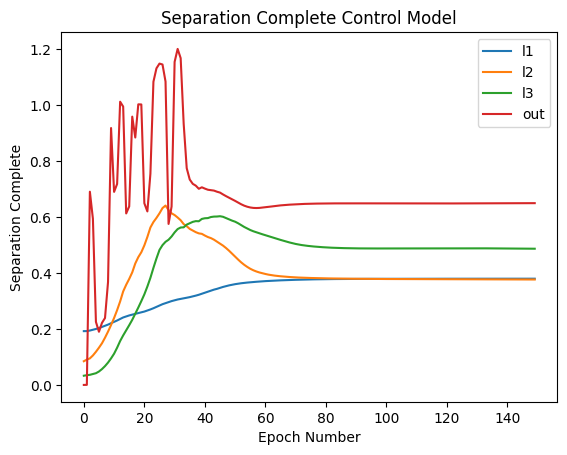

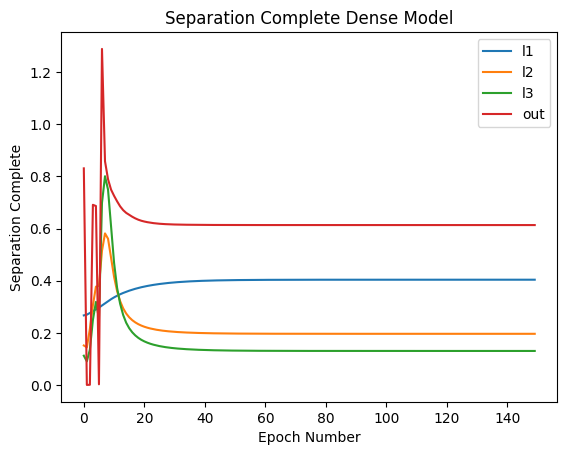

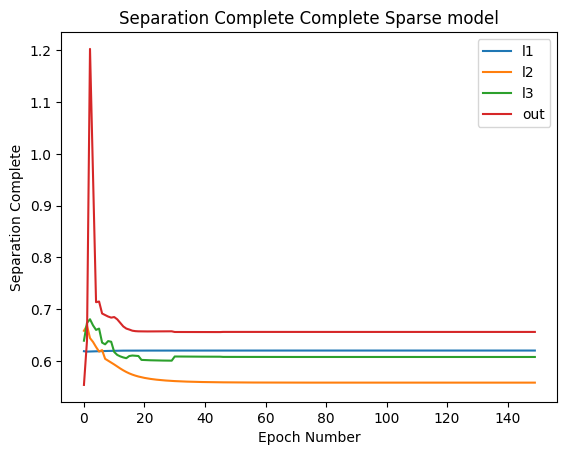

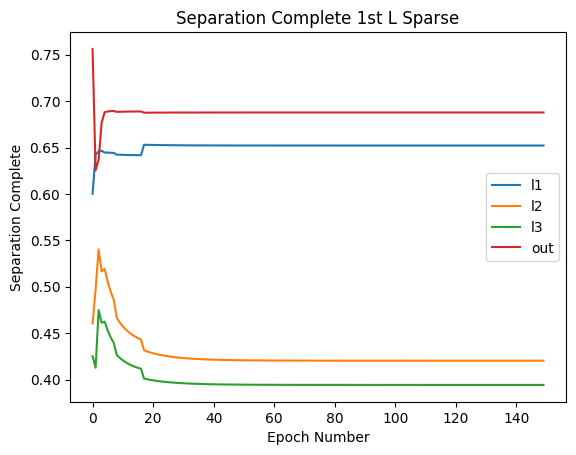

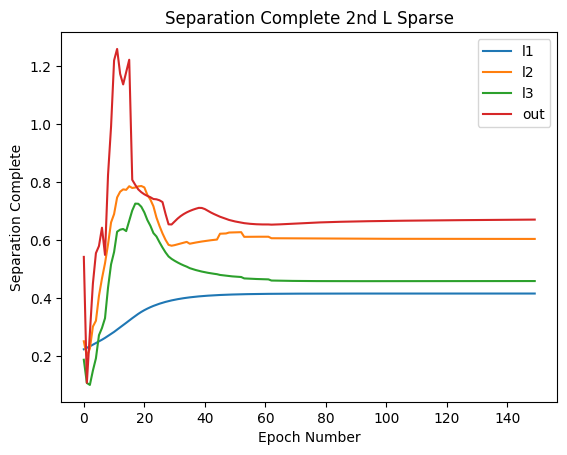

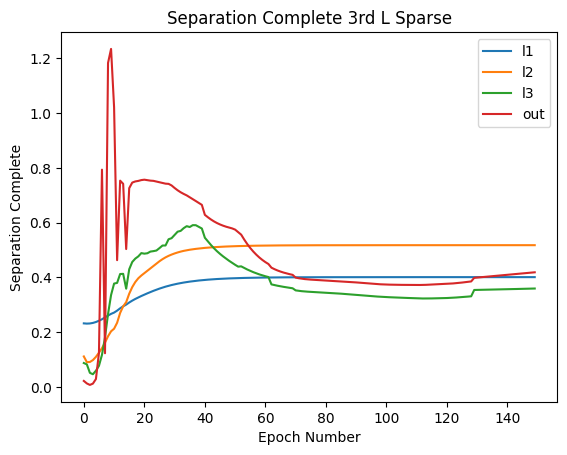

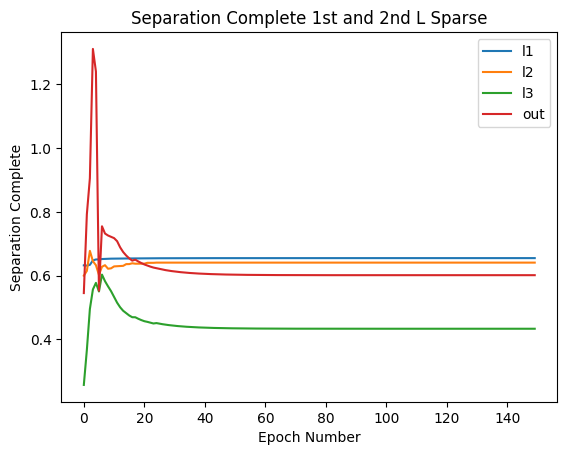

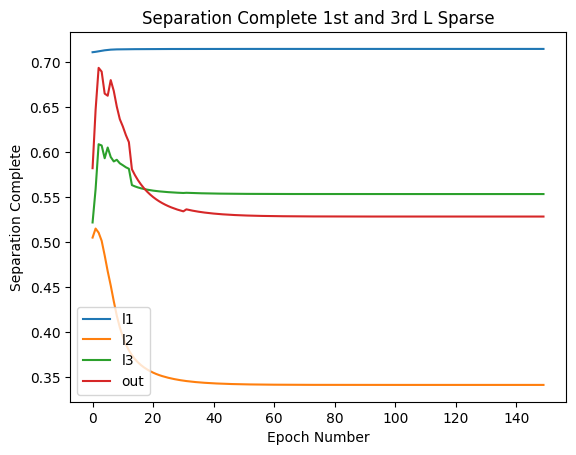

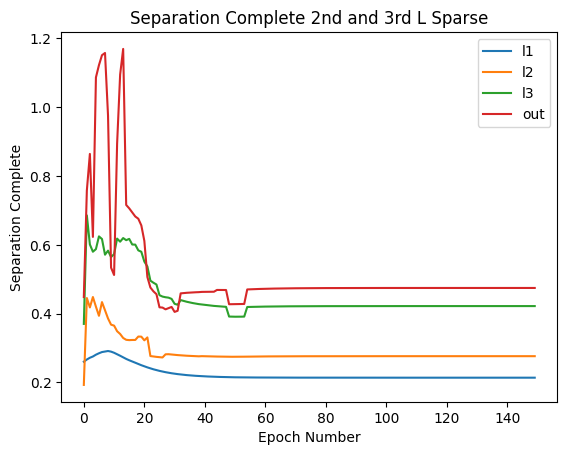

In [30]:
import numpy as np
figures = {}
xData = np.arange(len(simmilarity_complete['Control Model']['l1']))
graphLabel = "Separation Complete"
for modelName in simmilarity_complete:
    fig, ax = plt.subplots()

    figures[modelName] = fig

    ax.set_xlabel("Epoch Number")
    ax.set_ylabel(graphLabel)

    for layerName in simmilarity_complete[modelName]:
        ax.plot(xData, 1 - np.asarray(simmilarity_complete[modelName][layerName]), label=layerName)

    ax.legend()
    ax.set_title(graphLabel + " " + modelName)

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_96467/549371654.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


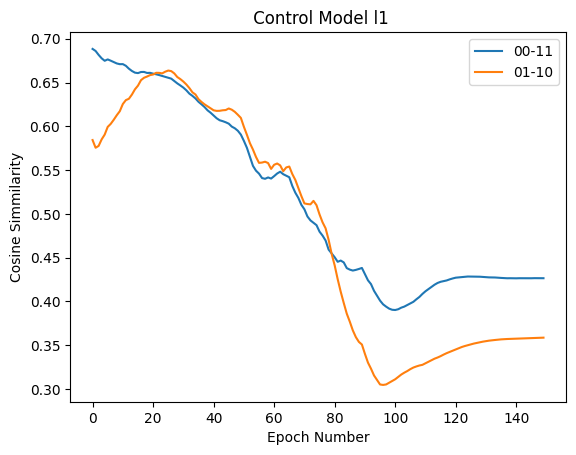

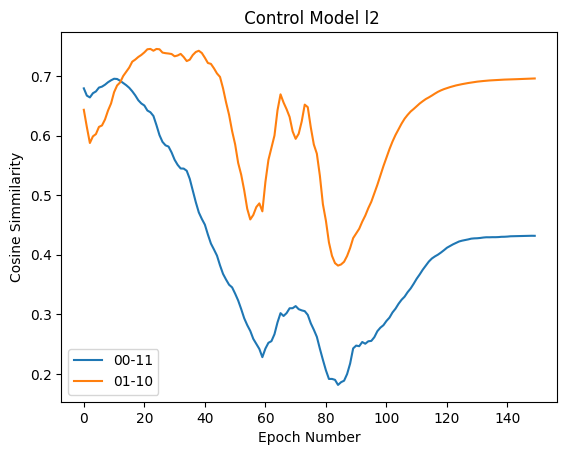

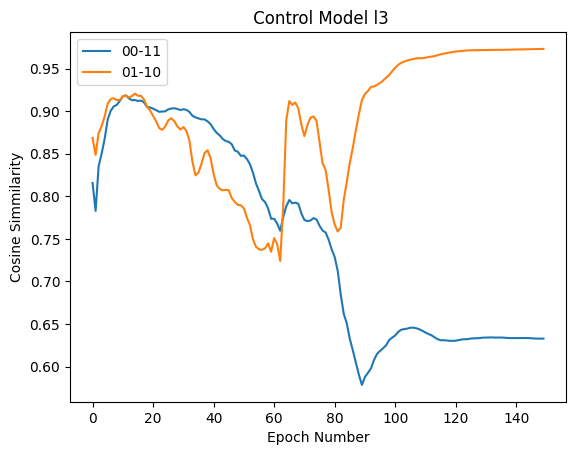

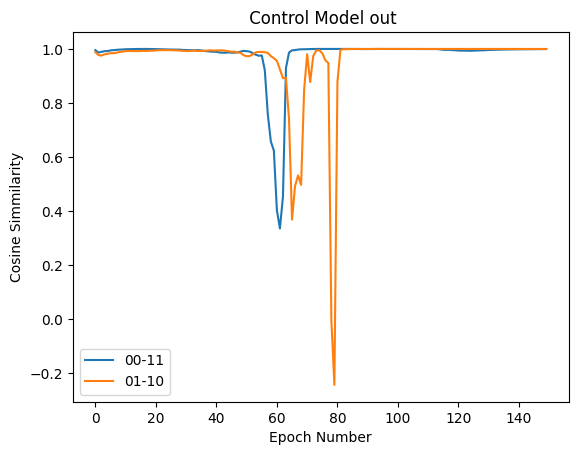

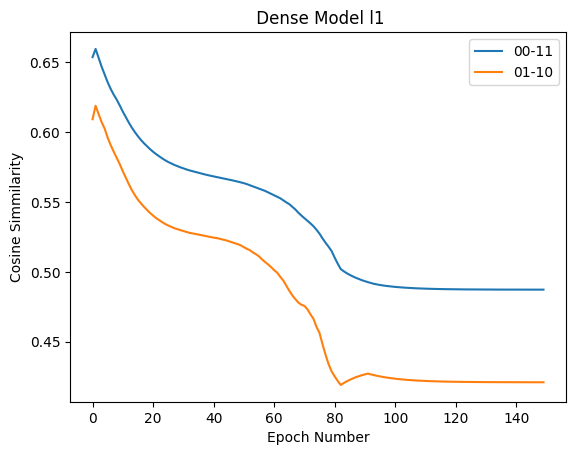

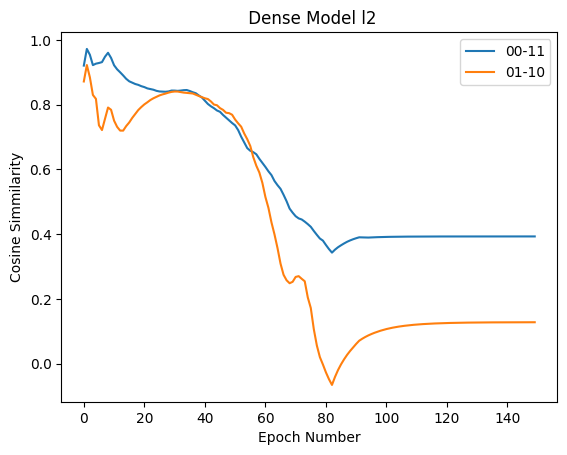

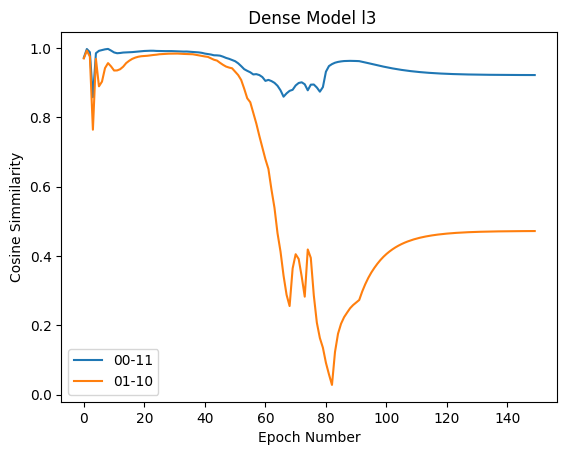

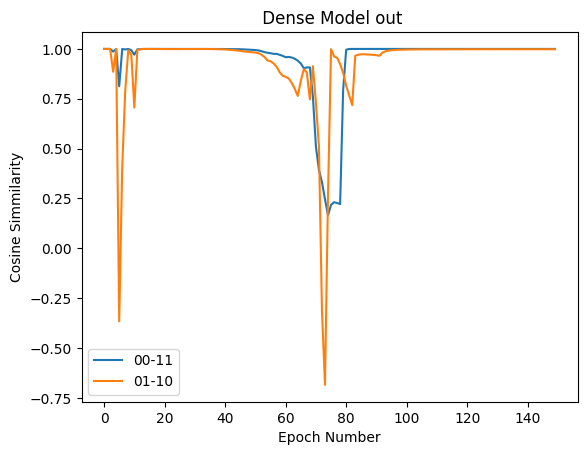

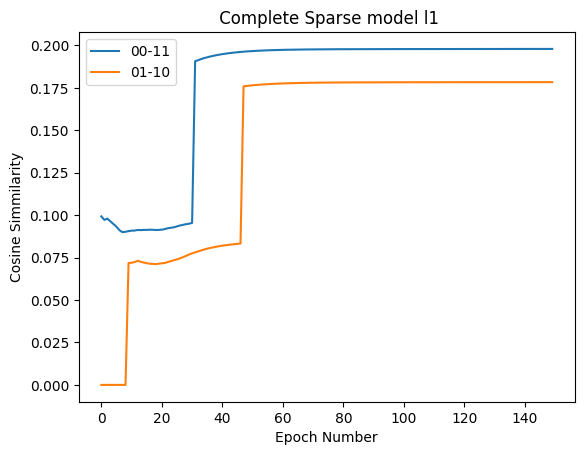

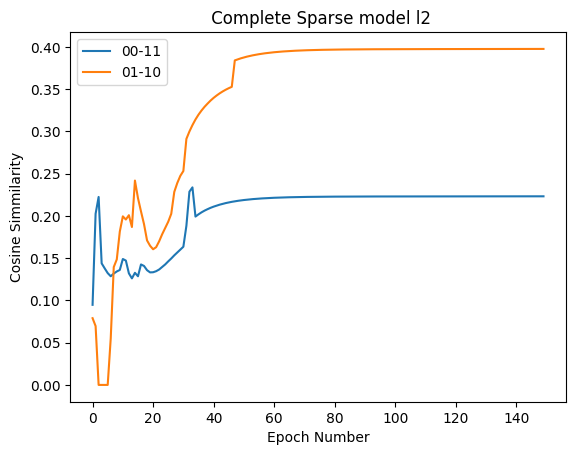

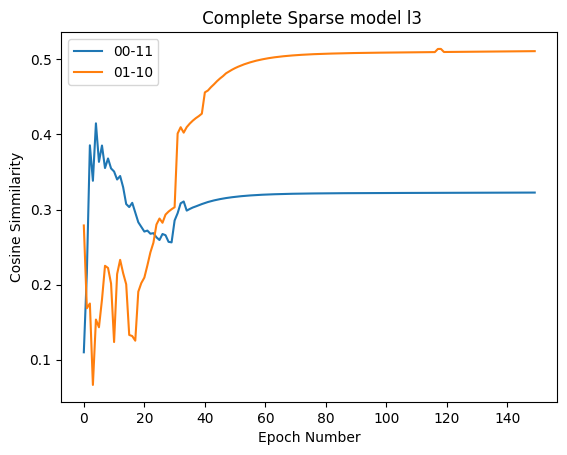

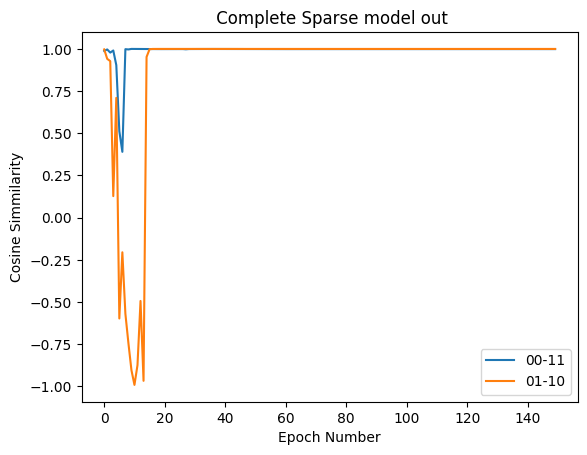

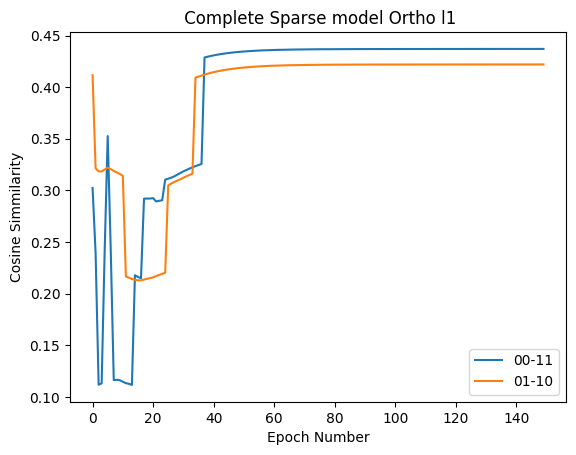

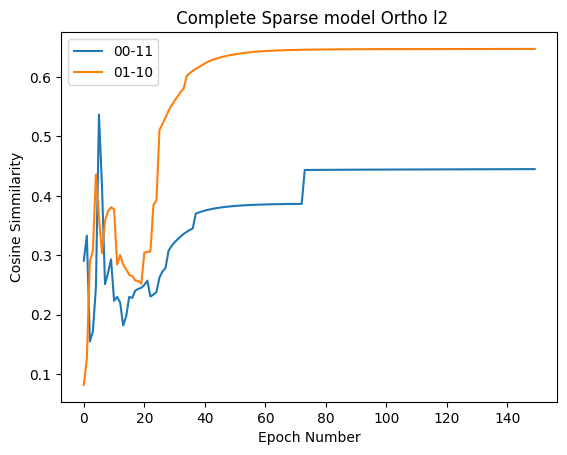

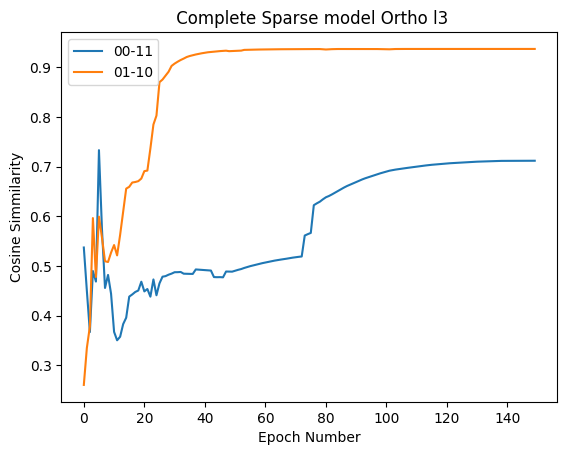

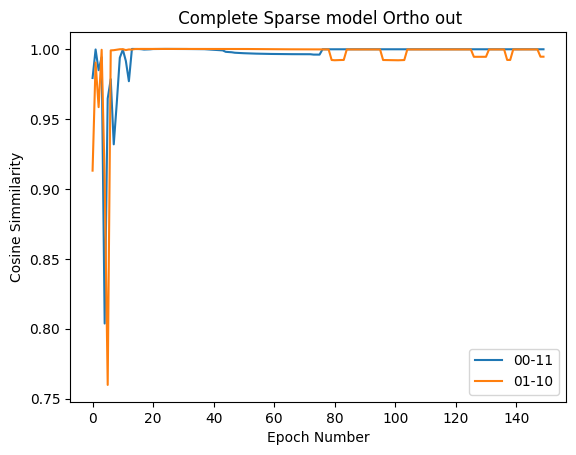

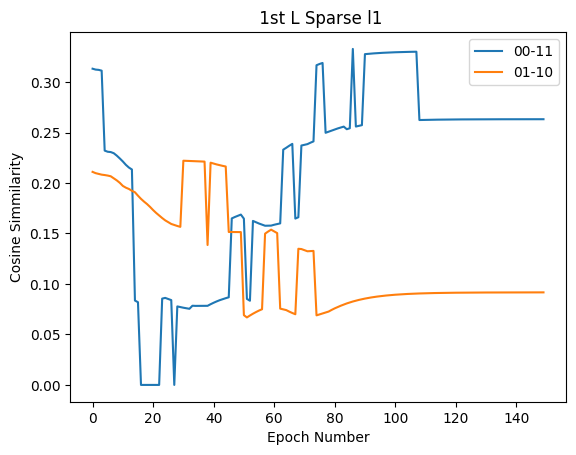

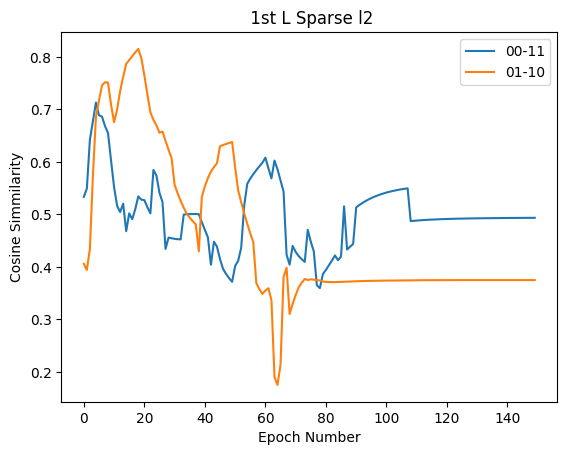

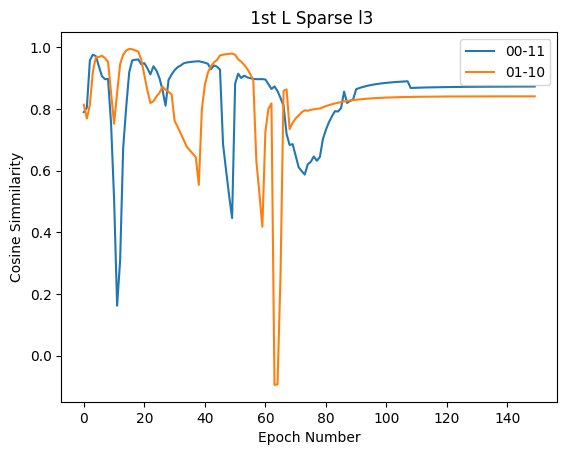

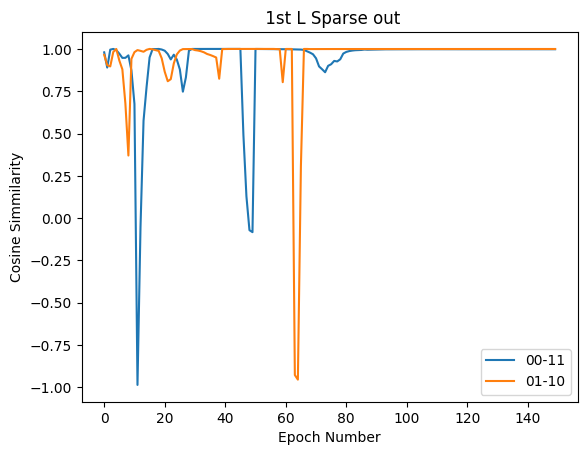

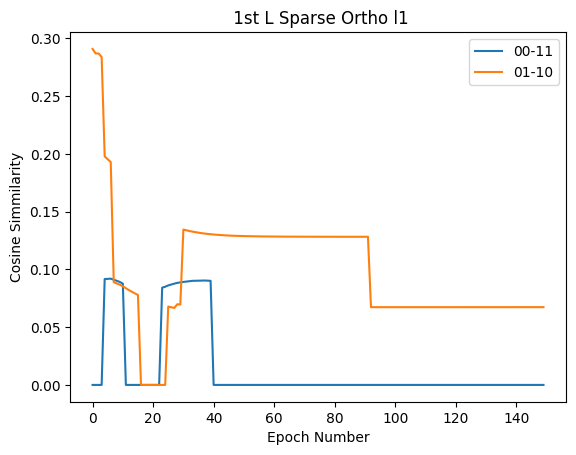

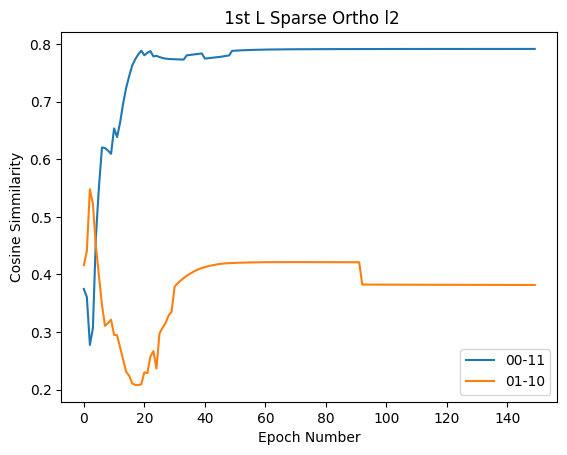

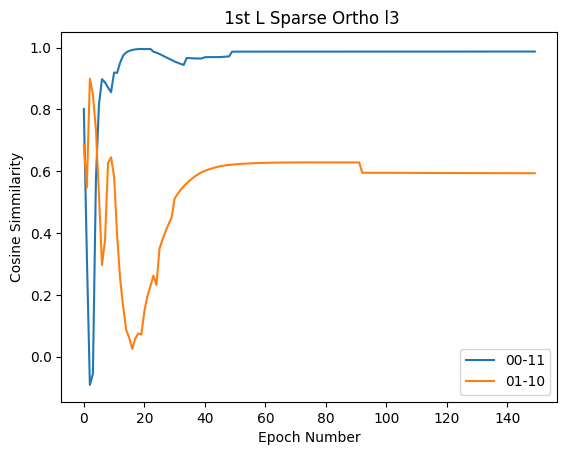

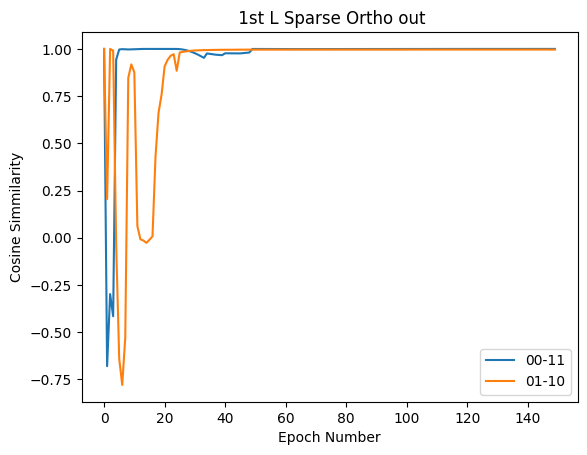

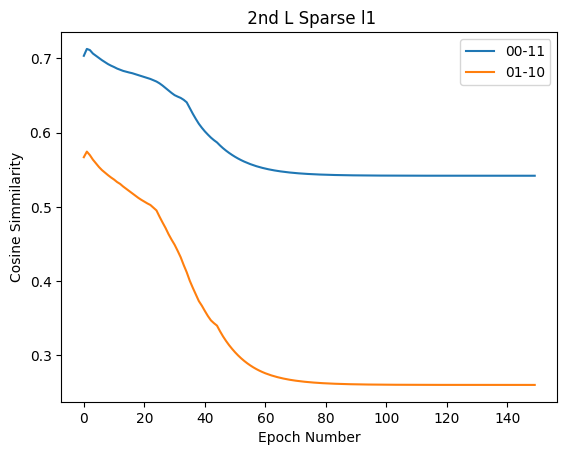

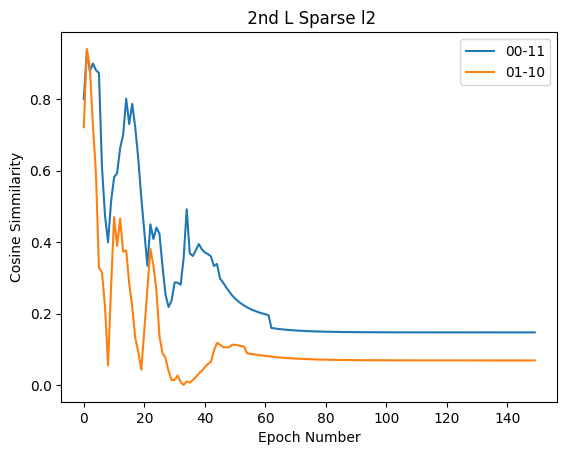

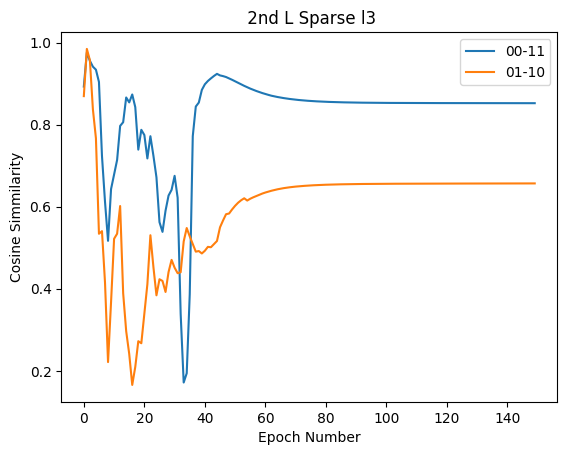

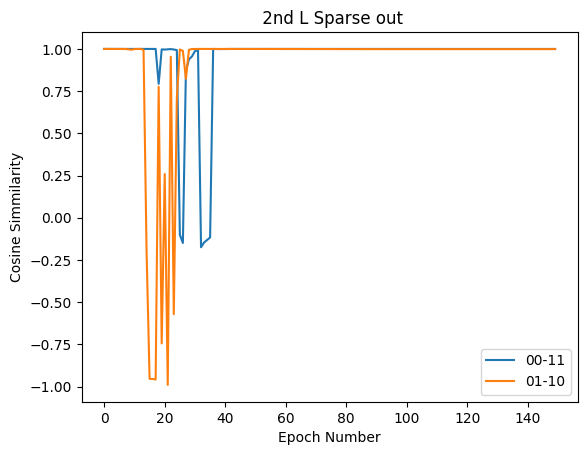

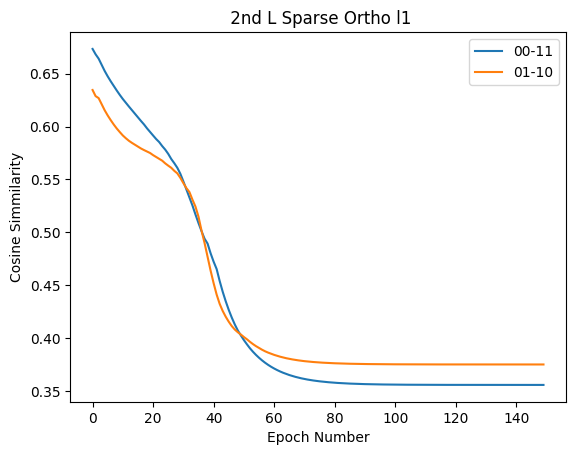

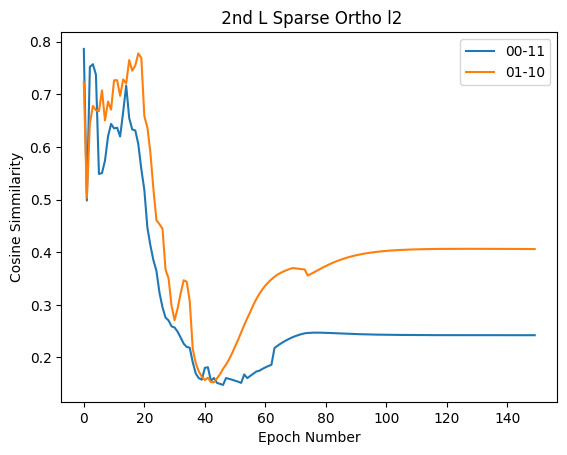

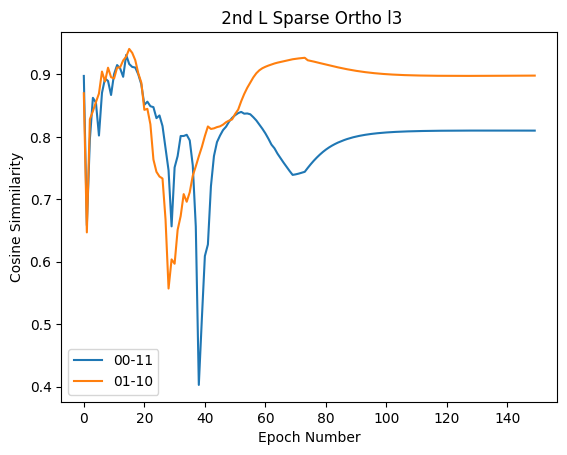

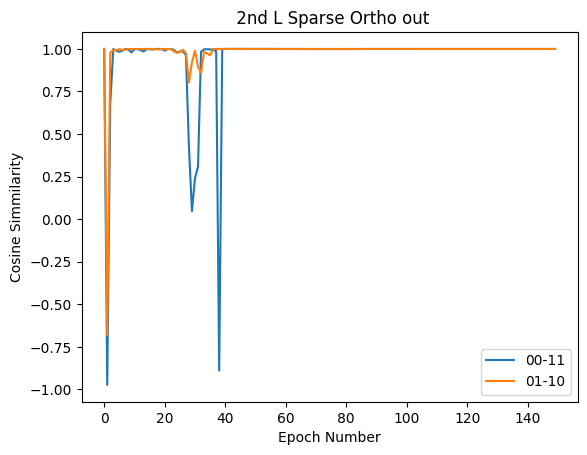

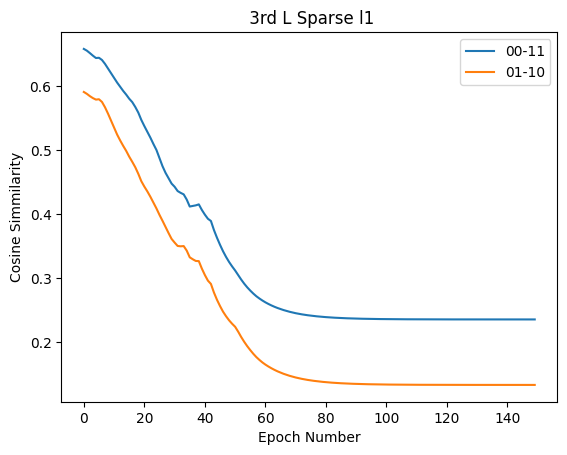

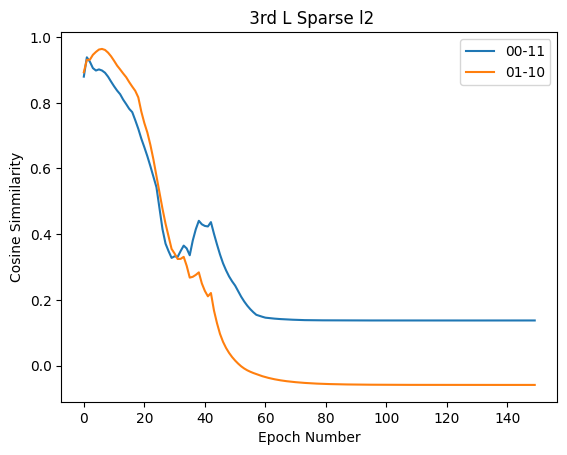

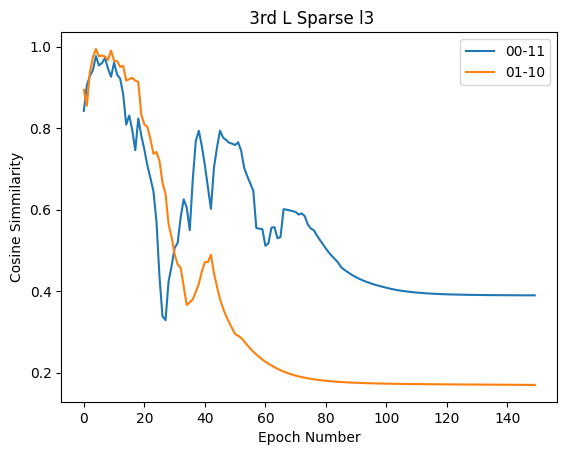

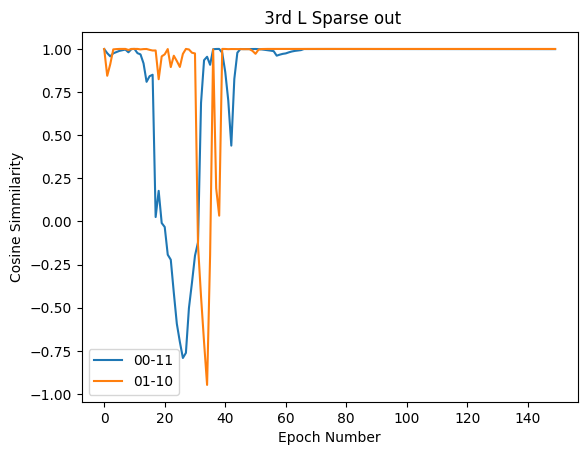

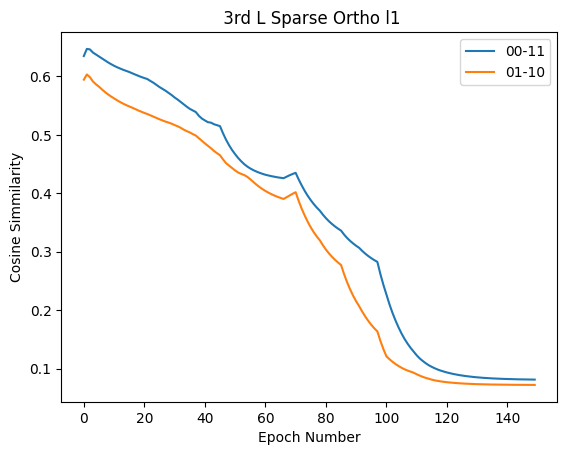

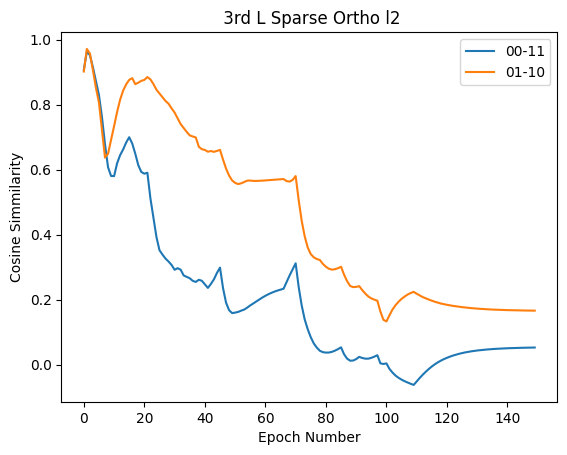

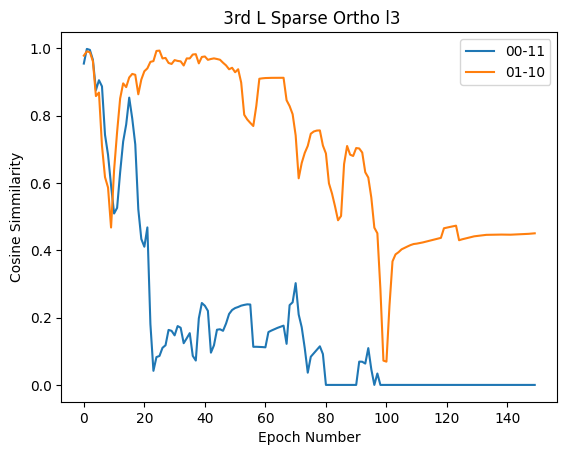

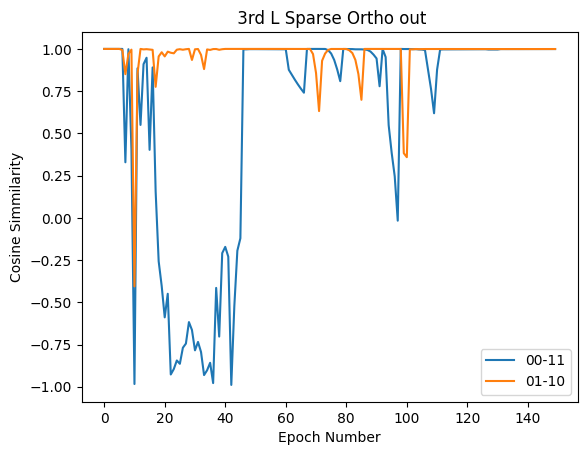

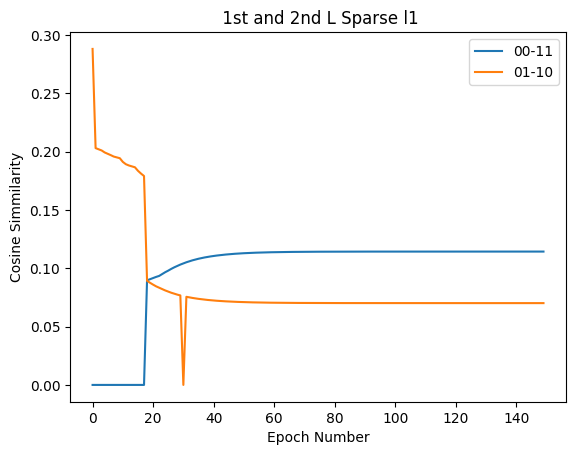

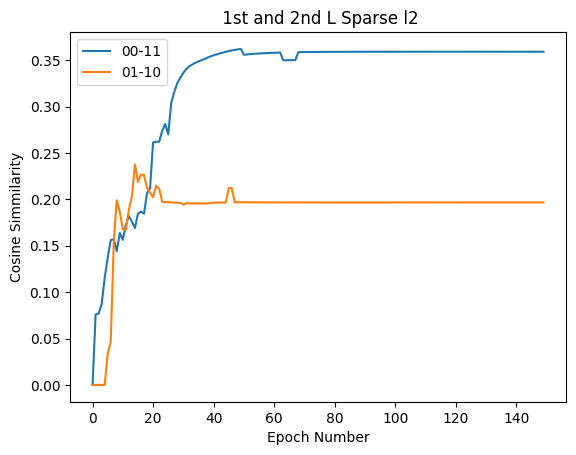

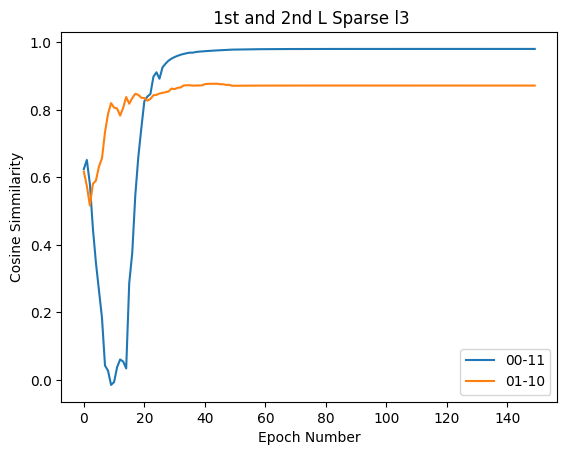

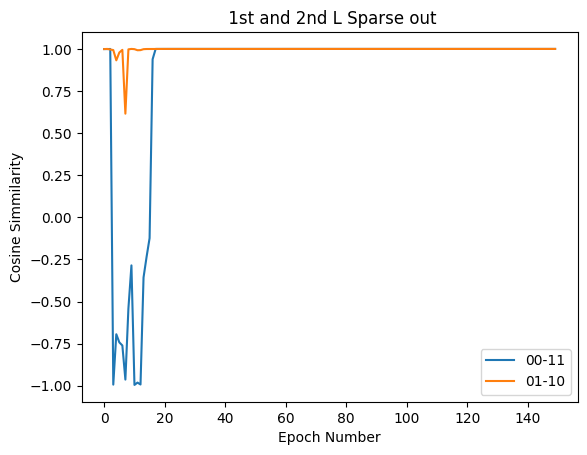

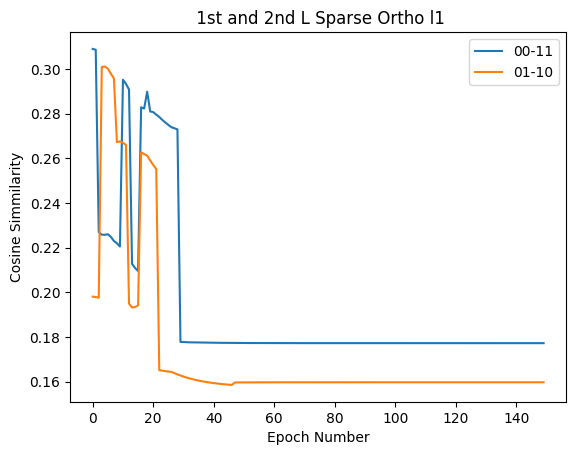

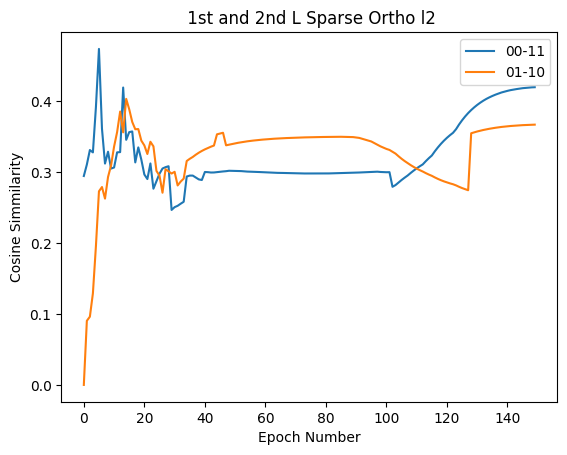

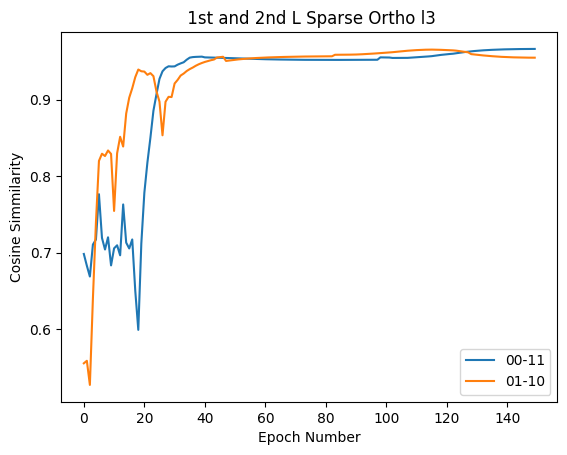

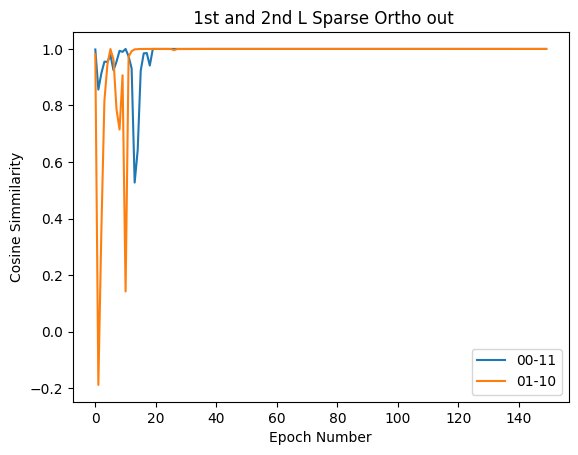

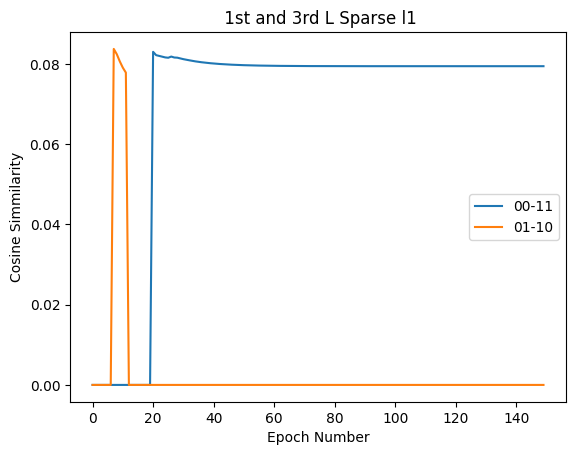

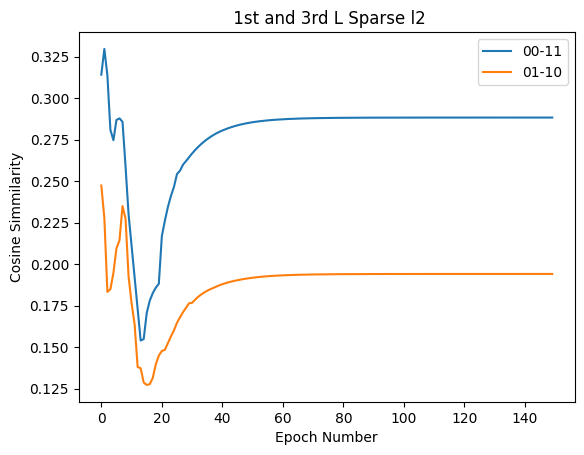

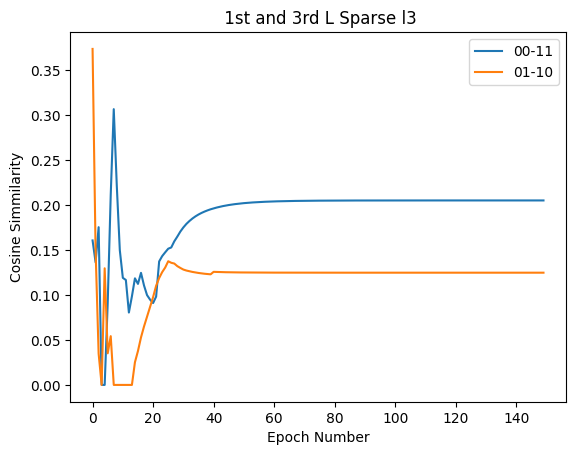

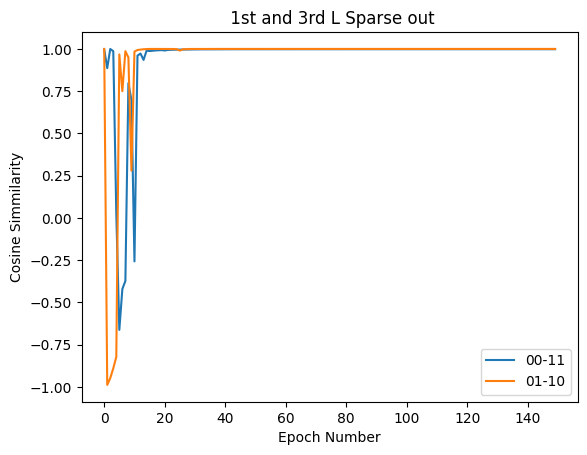

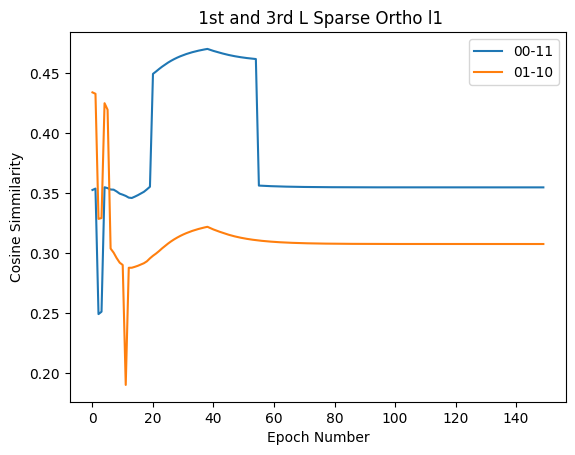

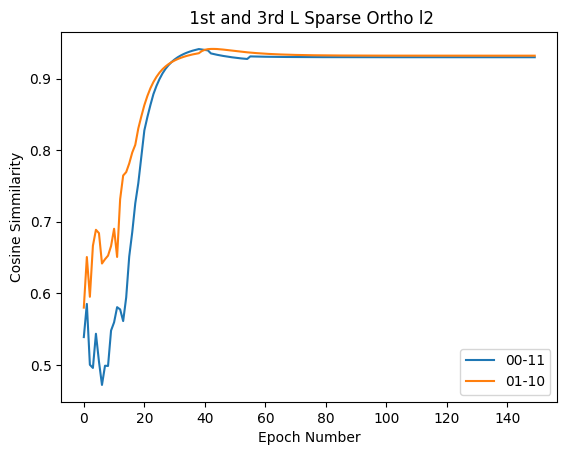

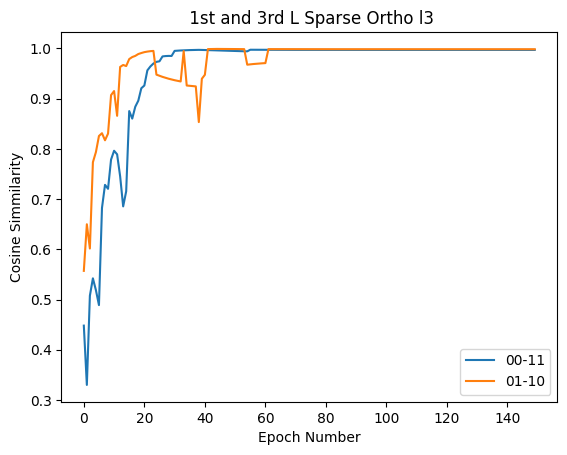

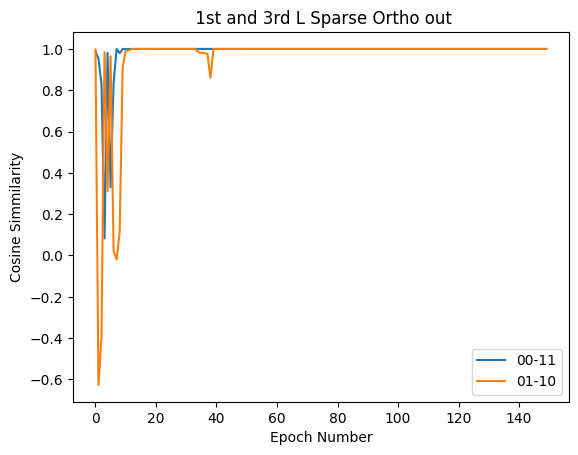

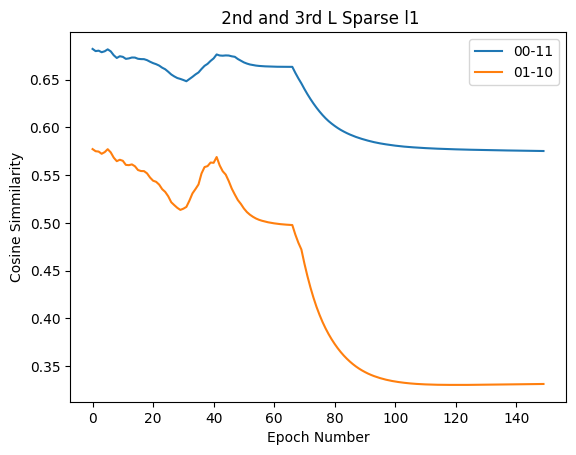

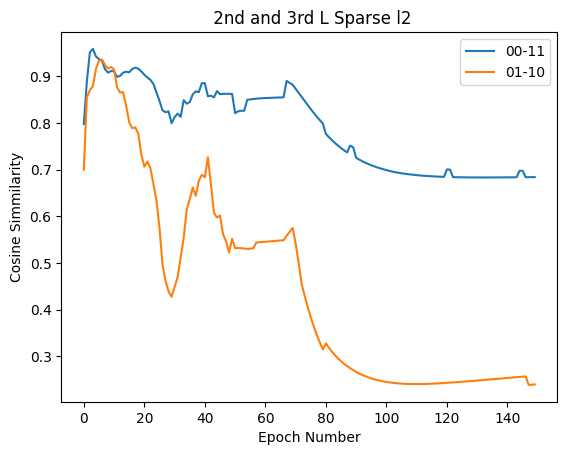

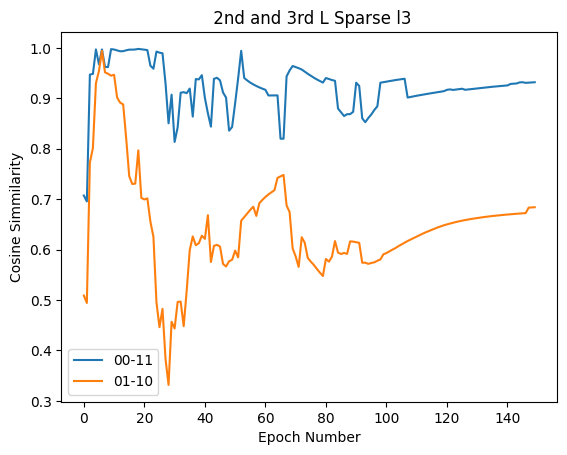

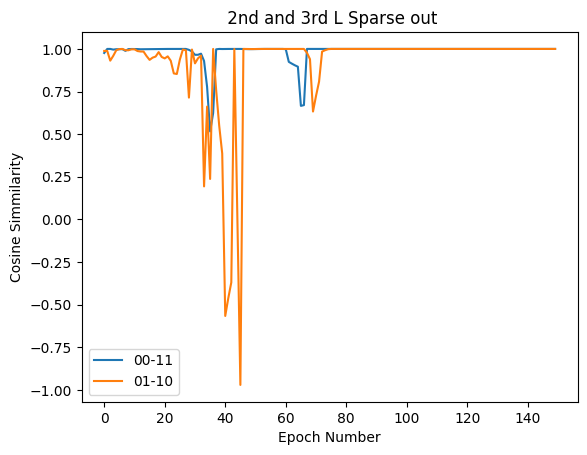

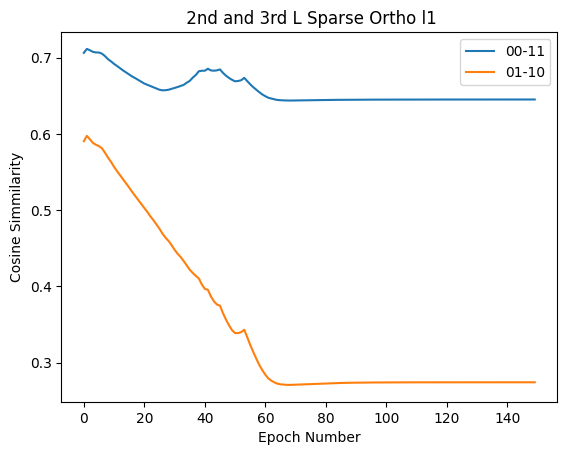

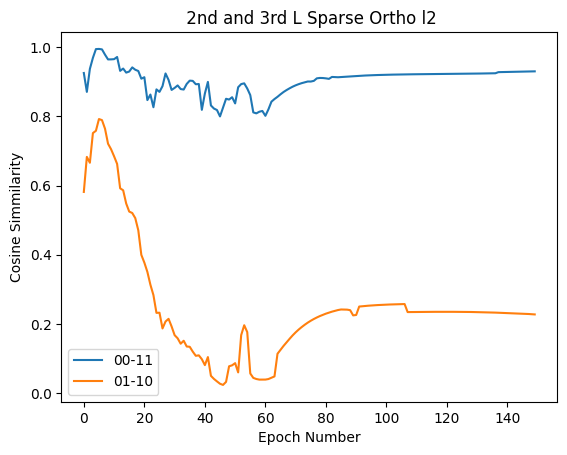

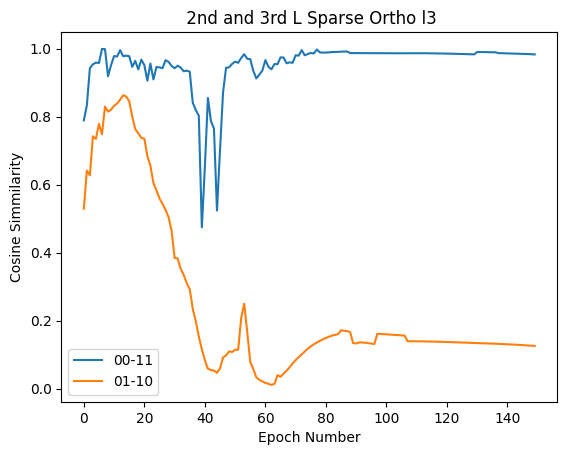

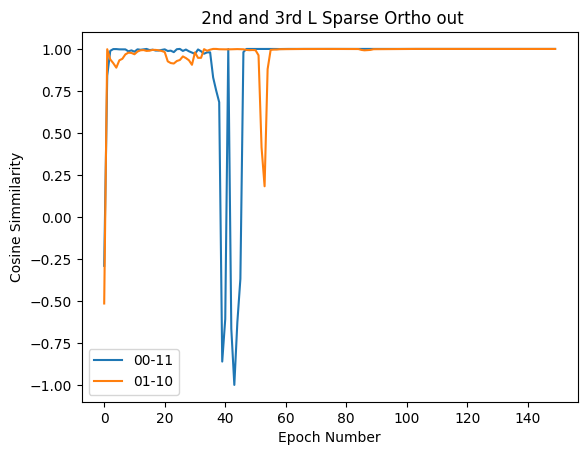

In [ ]:
figures = {}
xData = np.arange(len(simmilarity_within['Control Model']['l1']))

for modelName in simmilarity_within:
    for layerName in simmilarity_within[modelName]:
        fig, ax = plt.subplots()
        if modelName not in figures.keys():
            figures[modelName] = {}

        figures[modelName][layerName] = fig
        ax.set_xlabel("Epoch Number")
        ax.set_ylabel("Cosine Simmilarity")

        values = {}
        for abs_values in simmilarity_within[modelName][layerName]:
            for value_key in abs_values:
                if value_key not in values.keys():
                        values[value_key] = []
                values[value_key].append(abs_values[value_key])
        for value_key in values:
            ax.plot(xData, values[value_key], label=value_key)

        ax.legend()
        ax.set_title(" " + modelName + " " + layerName)

In [ ]:
chartUtils = ChartSparseUtil()
n_runs = 50
for _ in range(n_runs):
    sparseResults = get_models()
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_val, y_val)
            if accuracy != 1.:
                print(modelName, accuracy)
    chartUtils.add_activations(sparseActivations)

In [ ]:
chartUtils.set_sparsity_across_layers()

In [ ]:
chartUtils.avg_sparsity['Control Model']

{'l1': np.float64(0.11000000283122063),
 'l2': np.float64(0.12224999994039536),
 'l3': np.float64(0.08450000118464232),
 'out': np.float64(0.1025)}

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_20884/2131502000.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


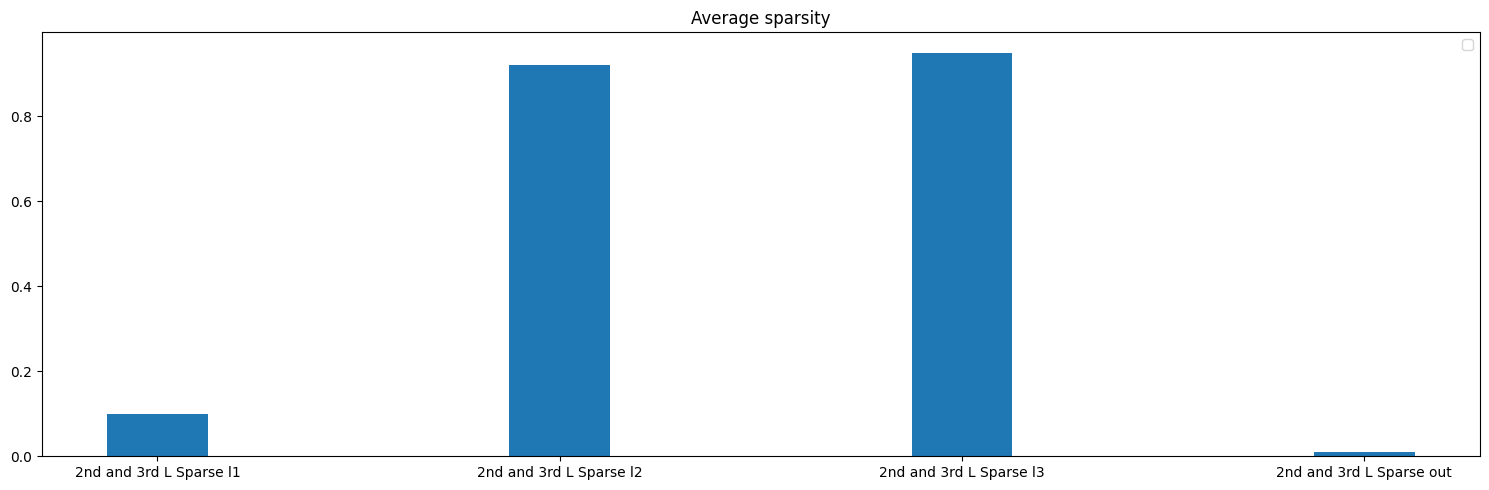

In [ ]:
chartUtils.plot_sparsity_across_layers()

In [ ]:
chartUtils.set_integration_separation()


/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_20884/1648615063.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


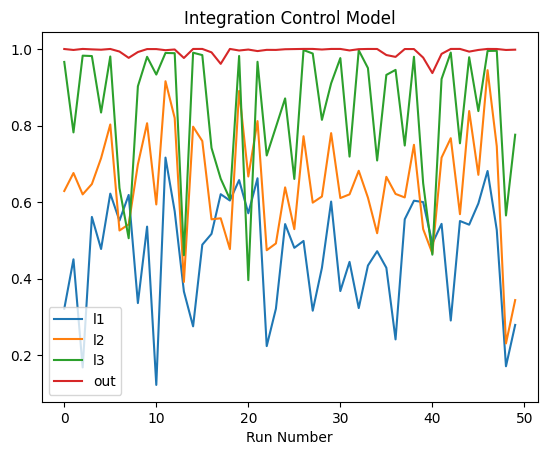

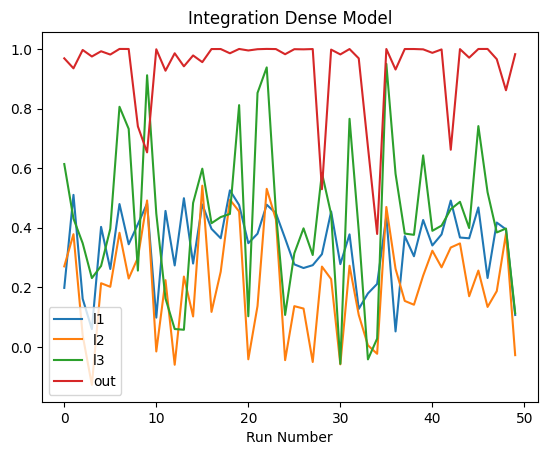

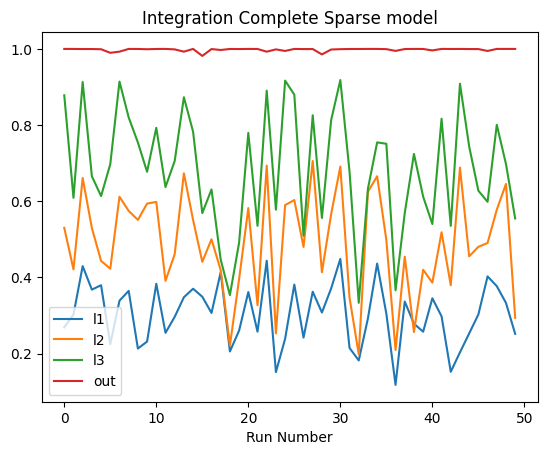

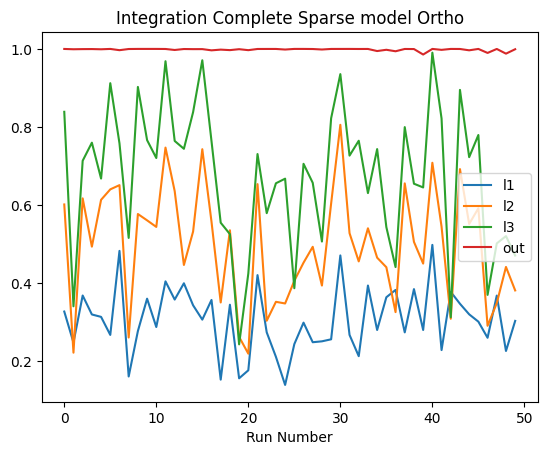

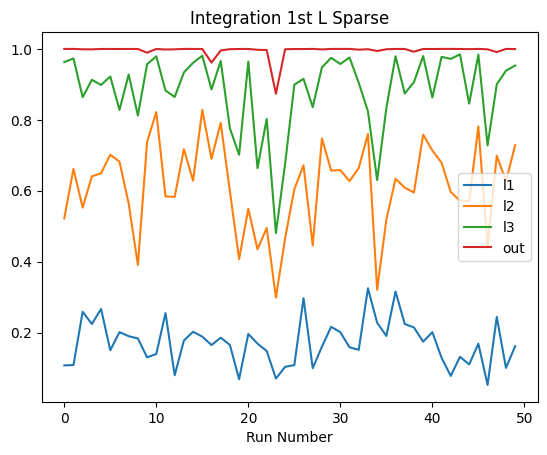

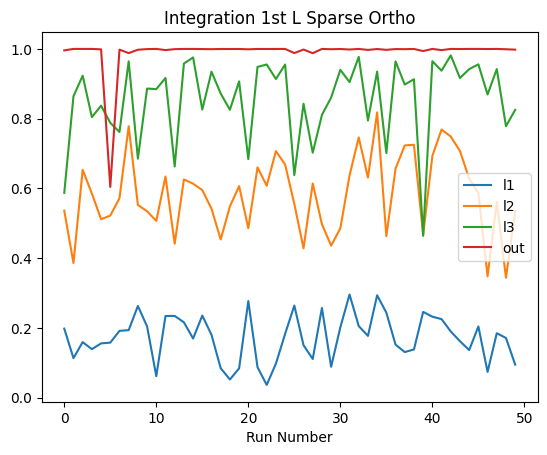

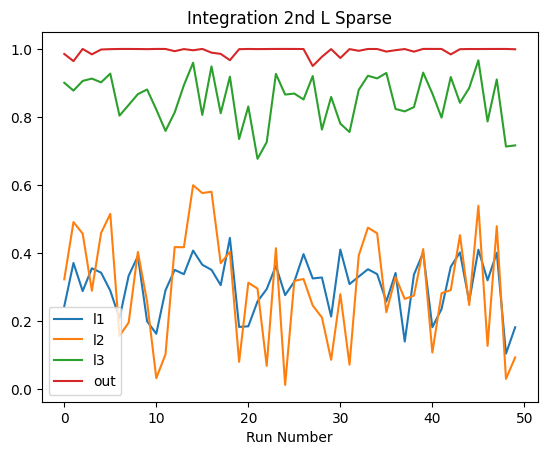

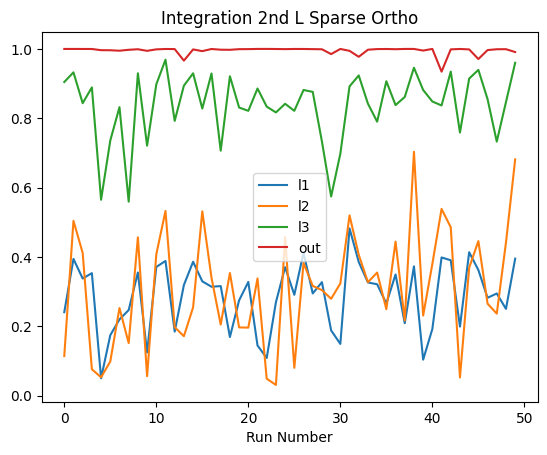

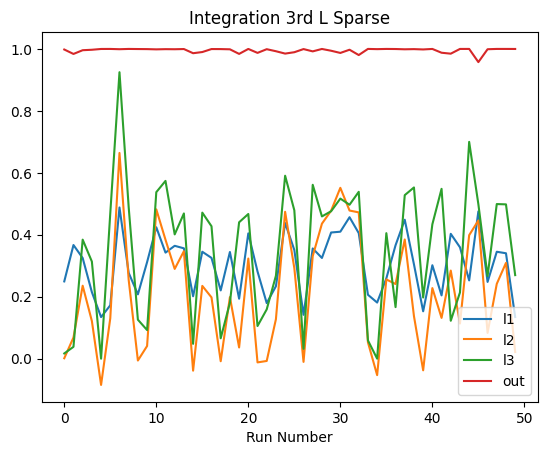

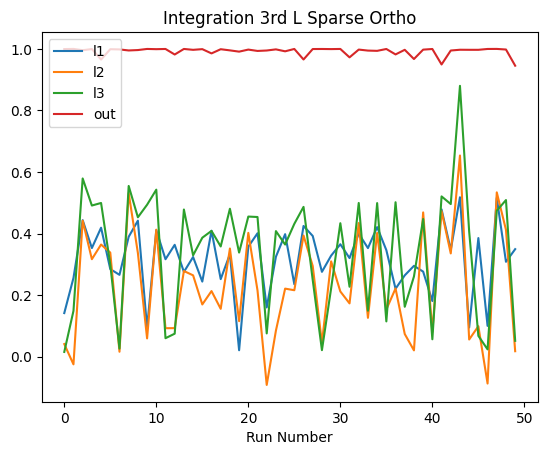

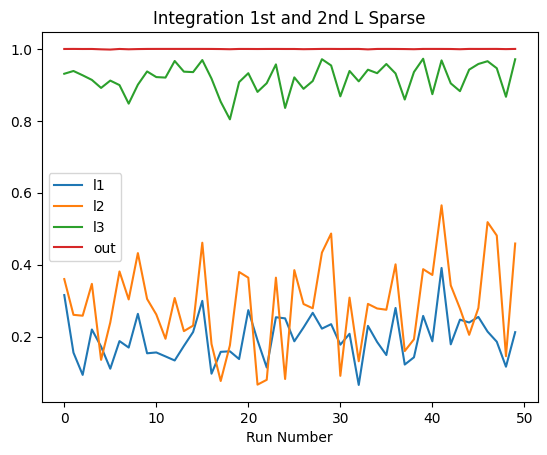

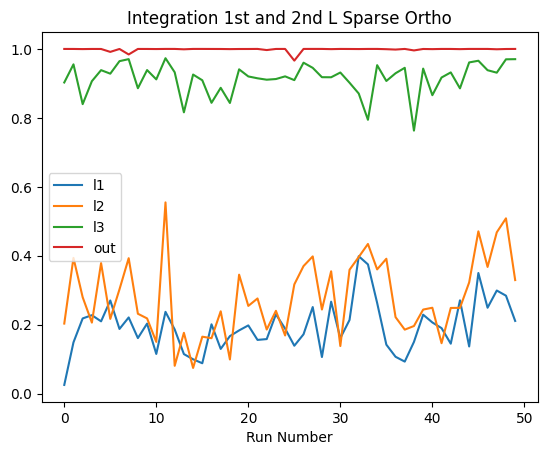

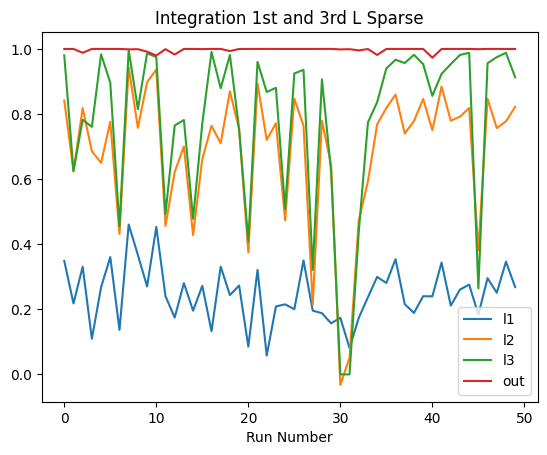

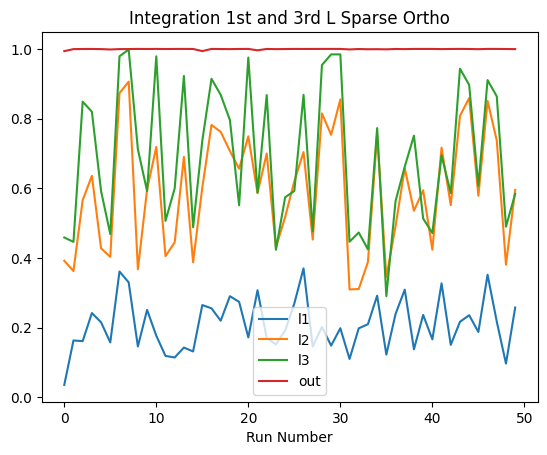

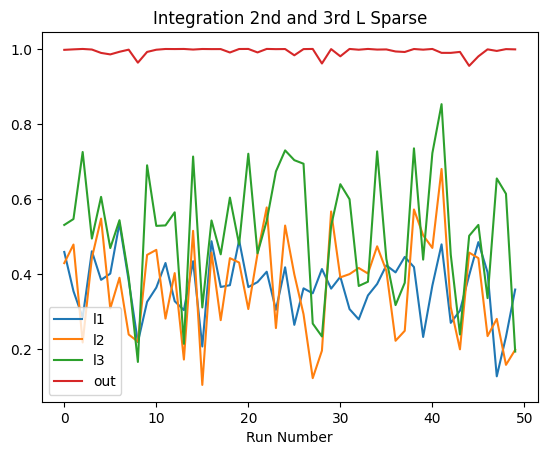

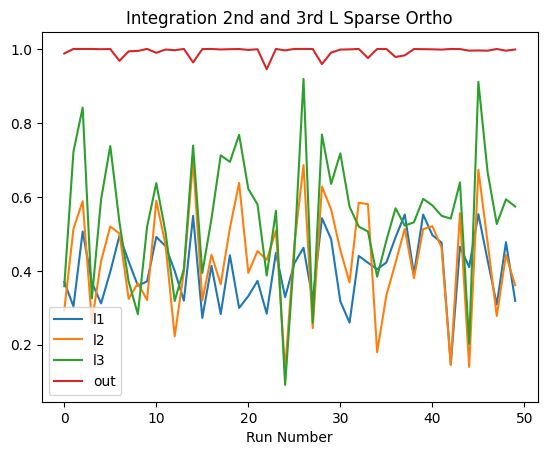

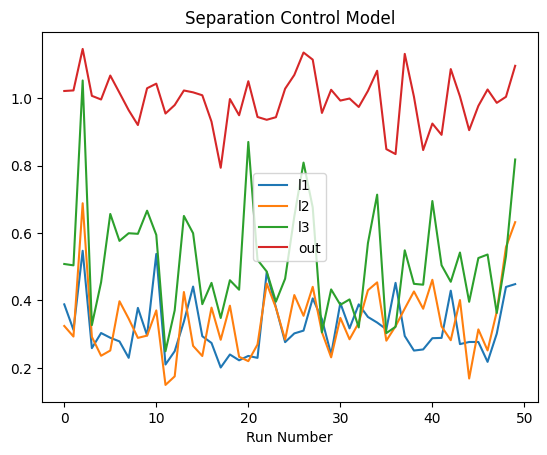

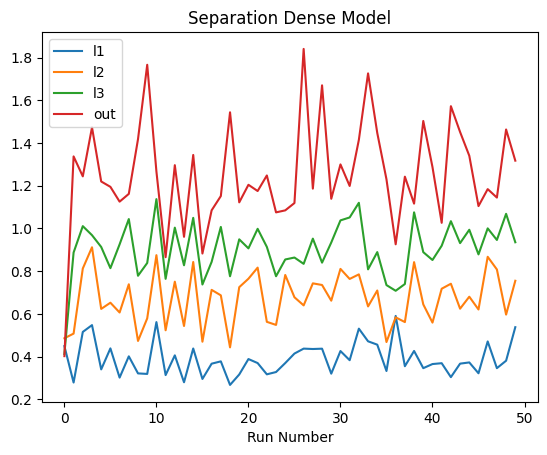

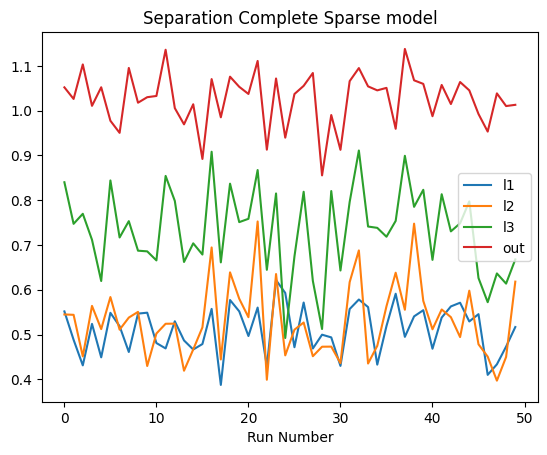

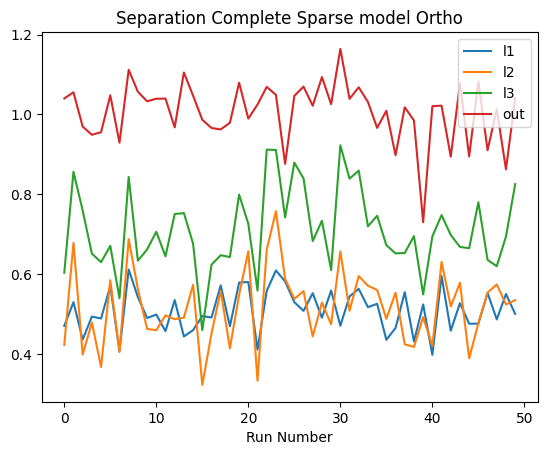

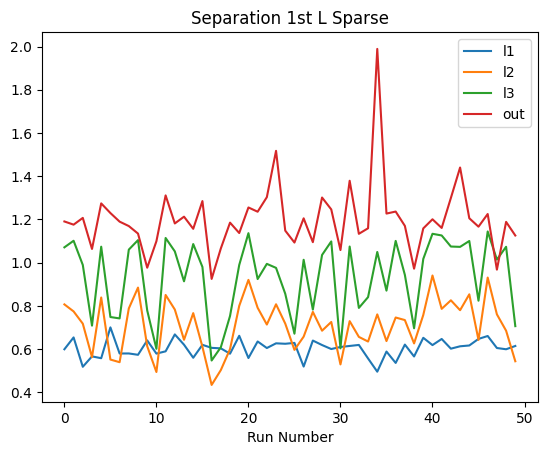

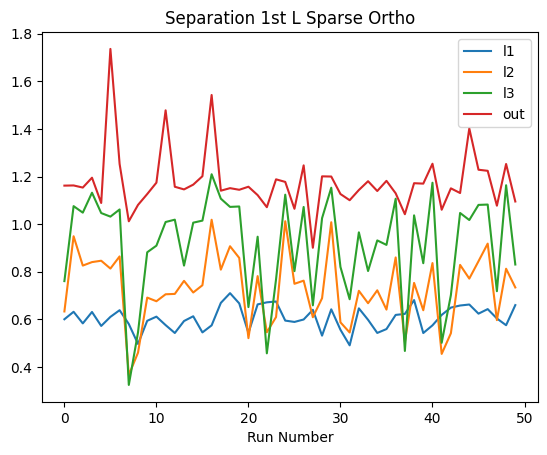

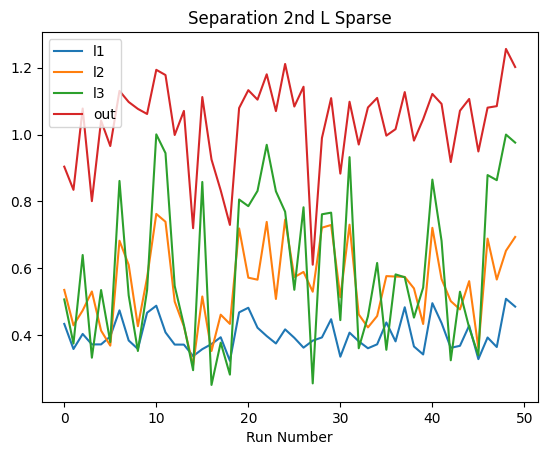

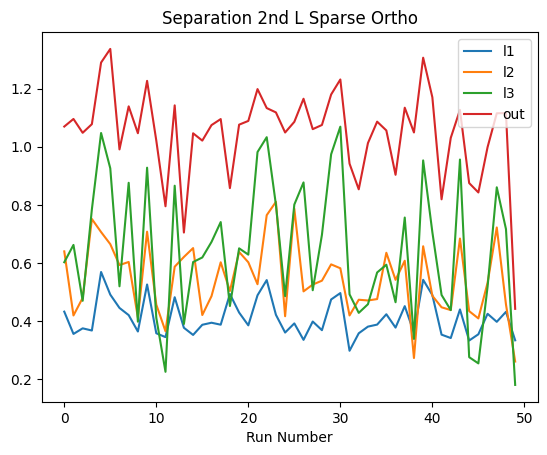

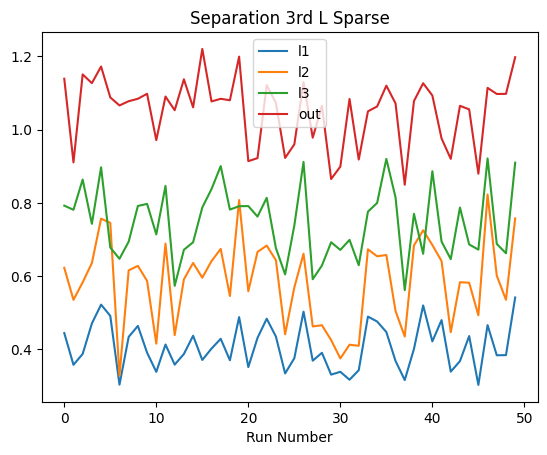

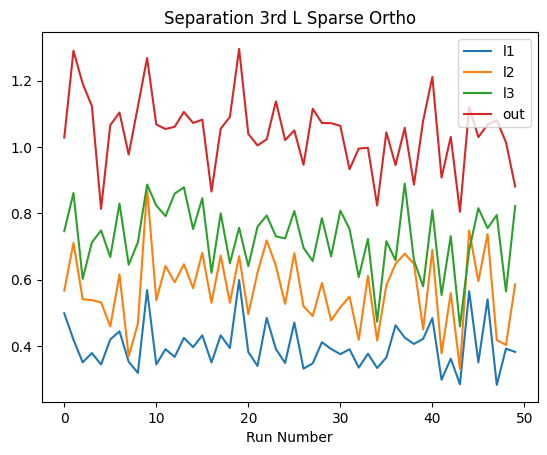

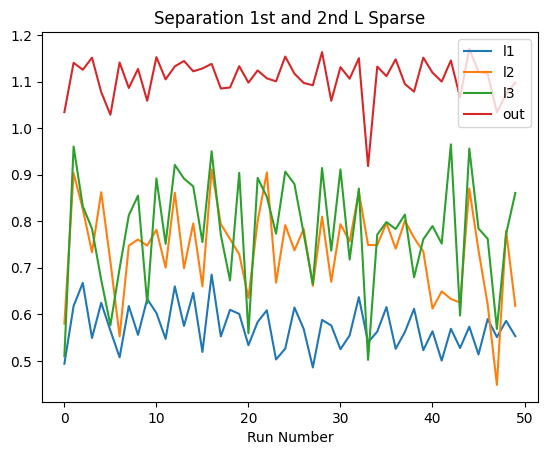

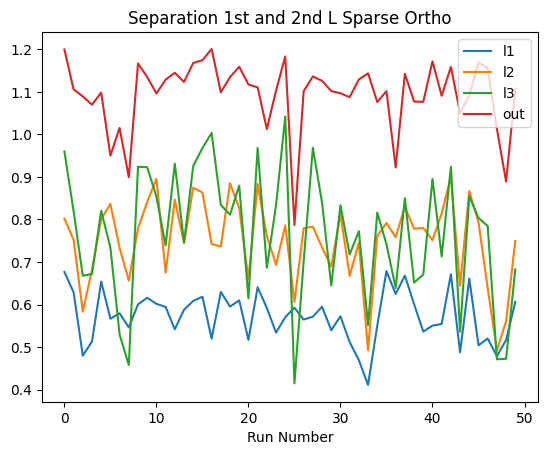

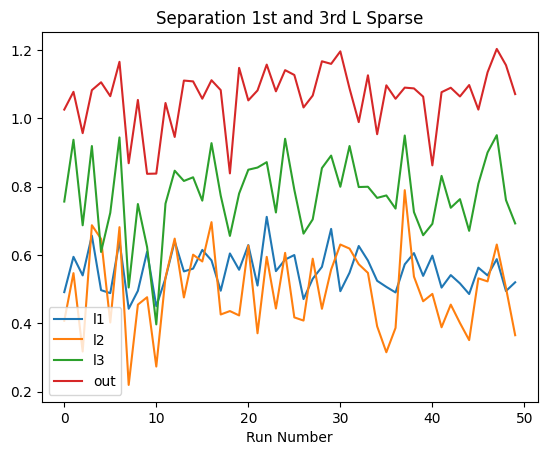

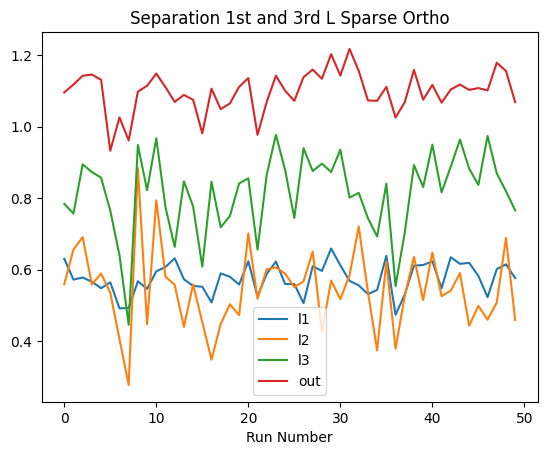

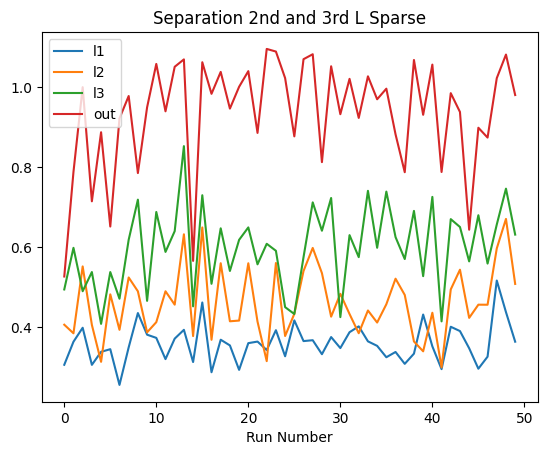

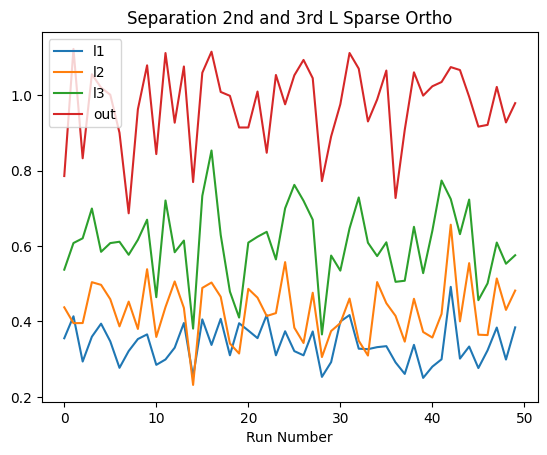

In [ ]:
figuresIntegration = chartUtils.get_integration_line_chart_across_runs()
figuresSeparation = chartUtils.get_separation_line_chart_across_runs()
# # figures = getErrorBarChart([integration, separation], ["Integration", "Separation"])
# combined = {}

# for key in integration.keys():
#     combined[key] = {}
#     for subkey in integration[key].keys():
#         combined[key][subkey] = [
#     {**i, **s} for i, s in zip(integration[key][subkey], separation[key][subkey])
#         ]
# figures = getErrorBarChartIndivid(combined)

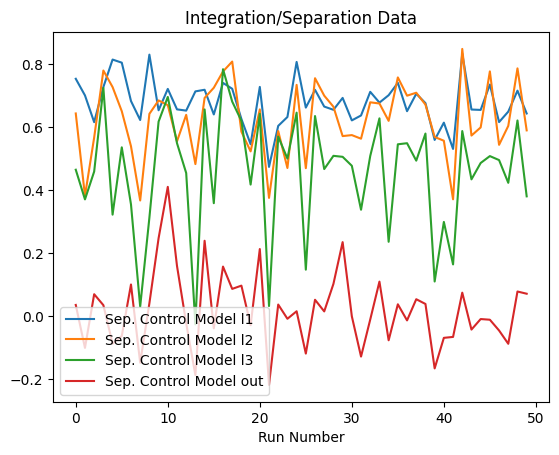

In [204]:
figures["Control Model"]['Sep.']

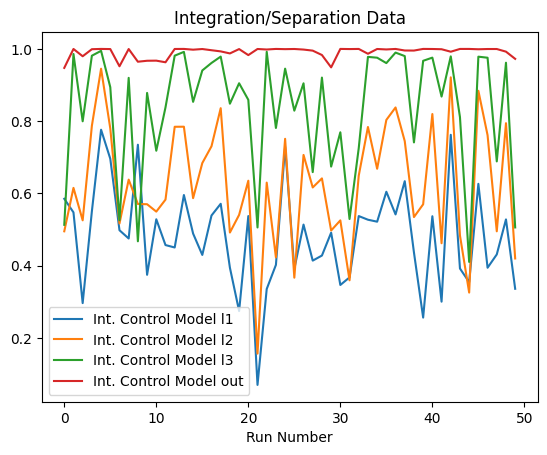

In [205]:
figures["Control Model"]['Int.']

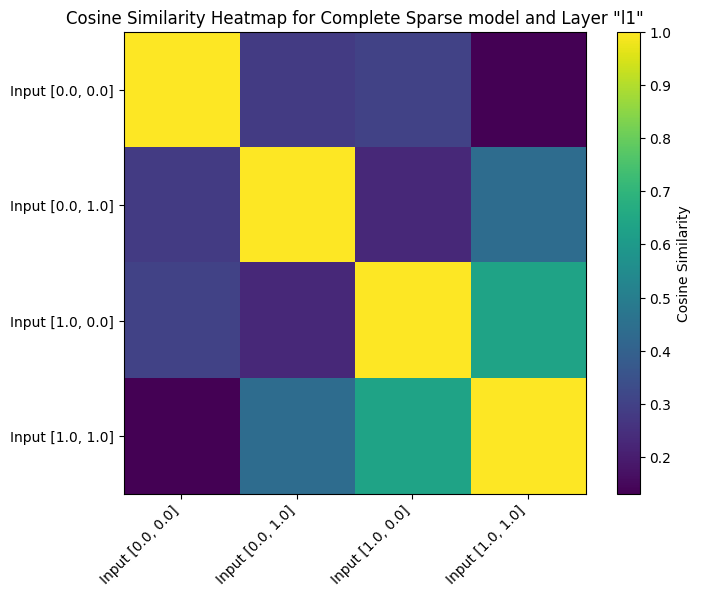

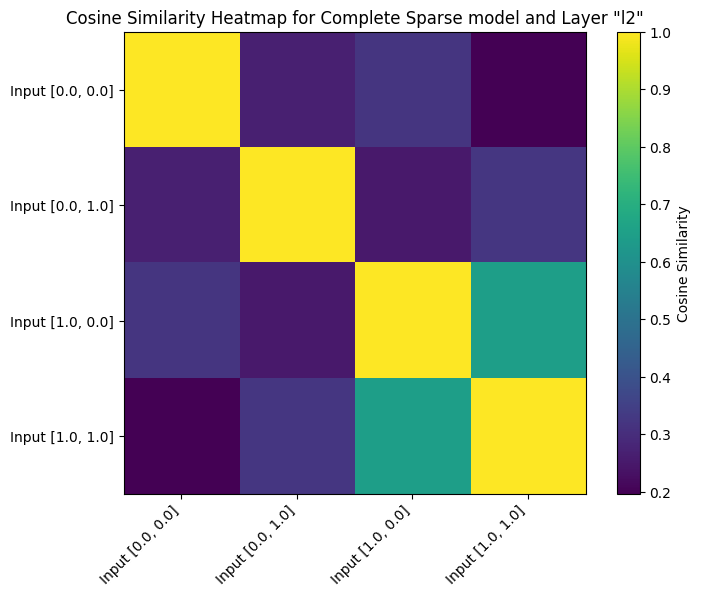

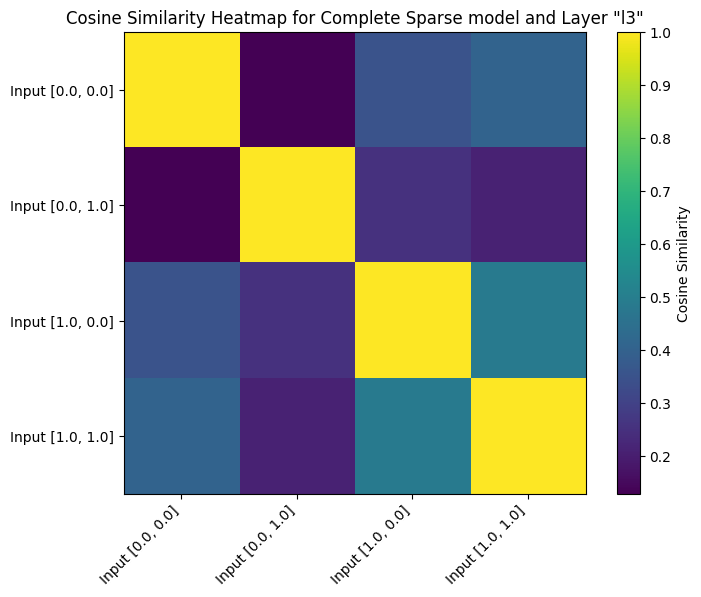

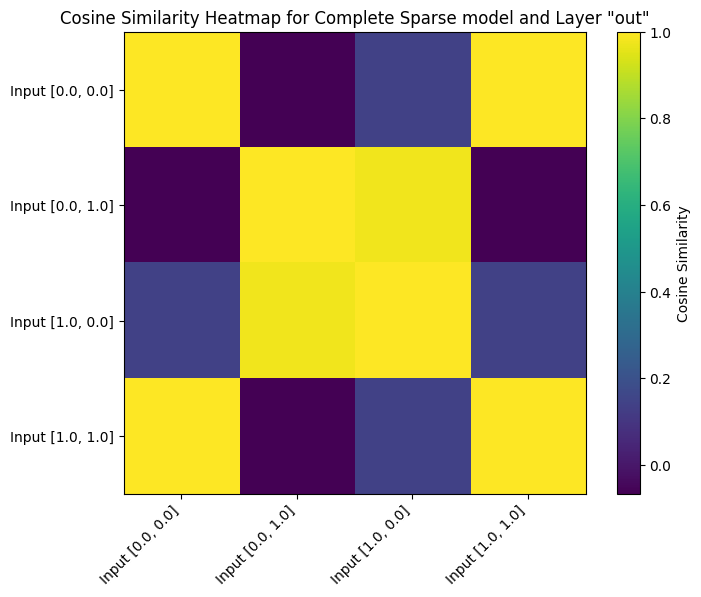

In [163]:
get_similarity_plot(sparseActivations['Complete Sparse model']['l1'], 'Complete Sparse model', 'l1')
get_similarity_plot(sparseActivations['Complete Sparse model']['l2'], 'Complete Sparse model', 'l2')
get_similarity_plot(sparseActivations['Complete Sparse model']['l3'], 'Complete Sparse model', 'l3')
fig = get_similarity_plot(sparseActivations['Complete Sparse model']['out'], 'Complete Sparse model', 'out')

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_20884/1296307577.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6))


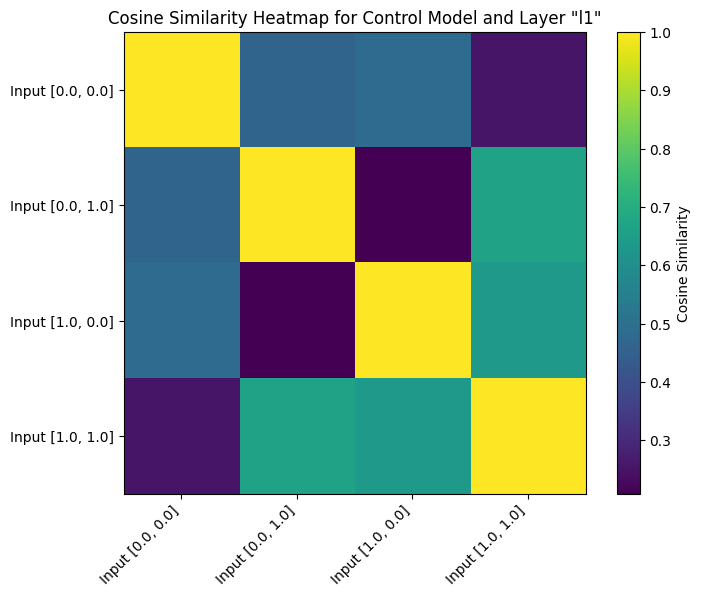

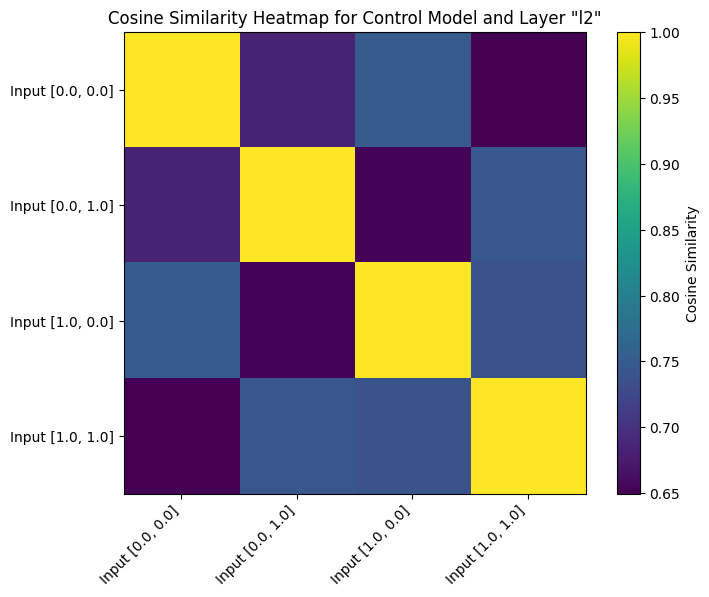

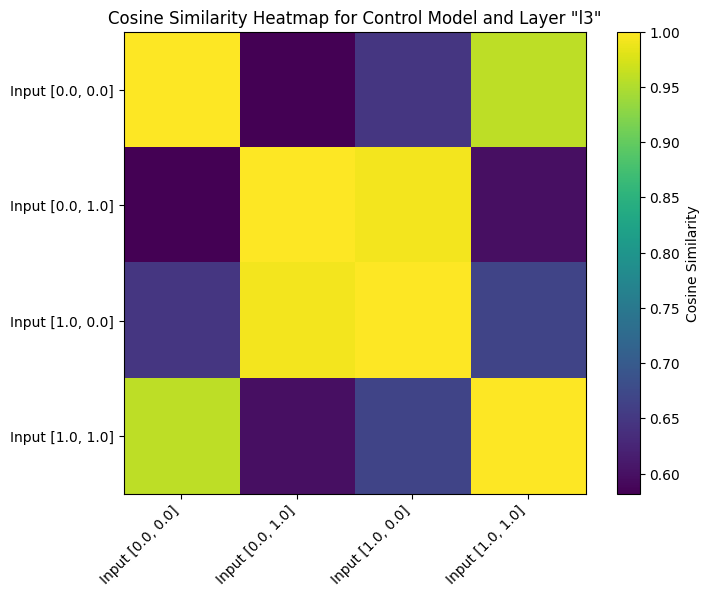

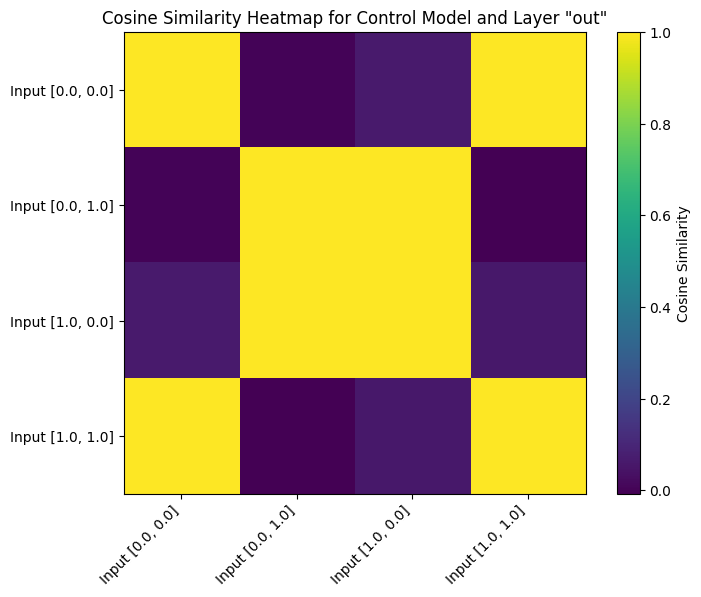

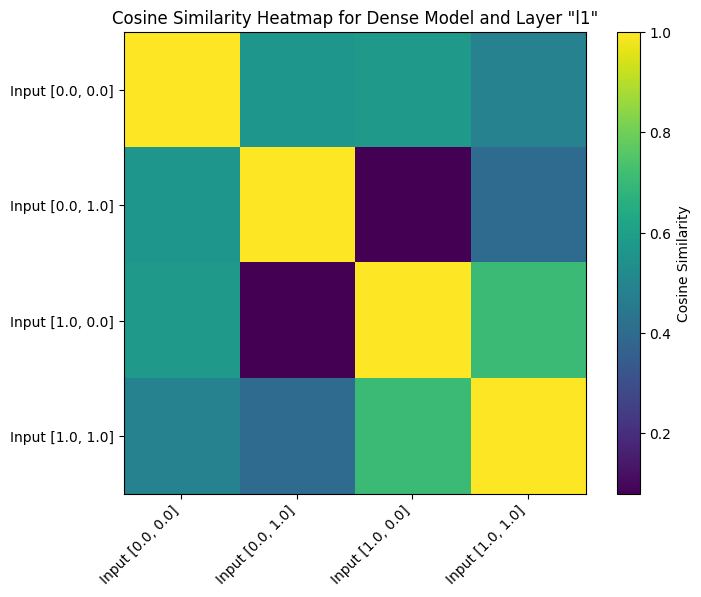

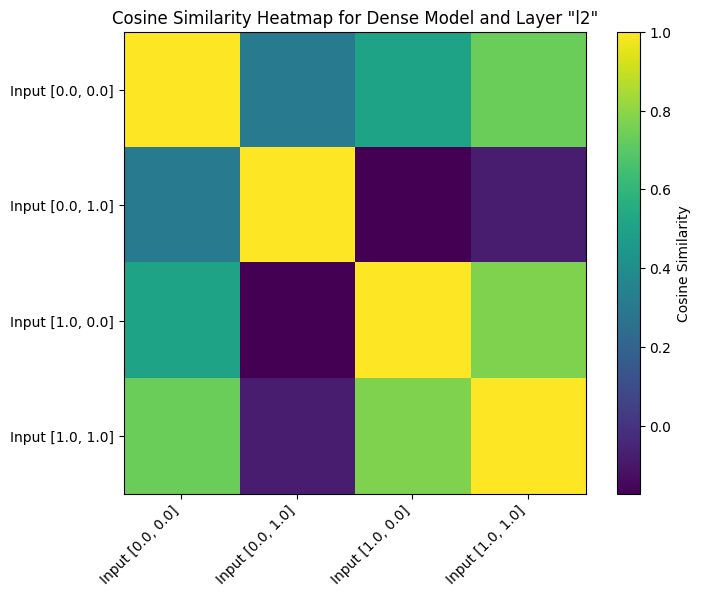

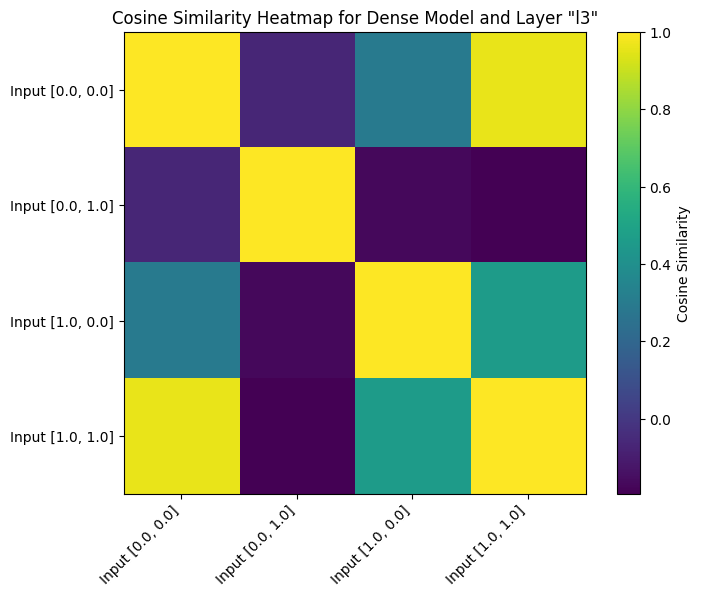

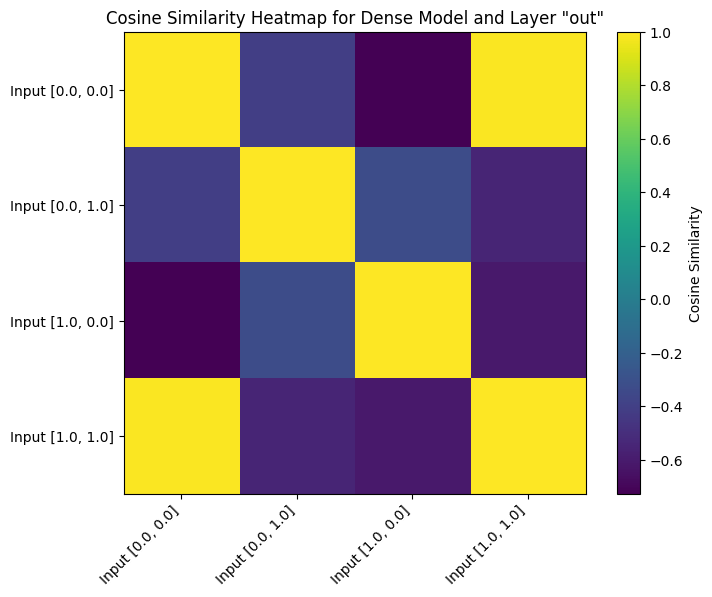

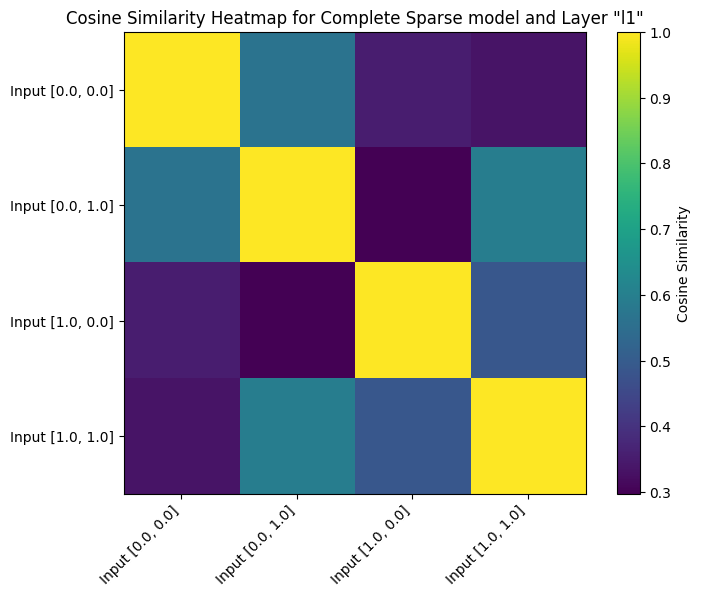

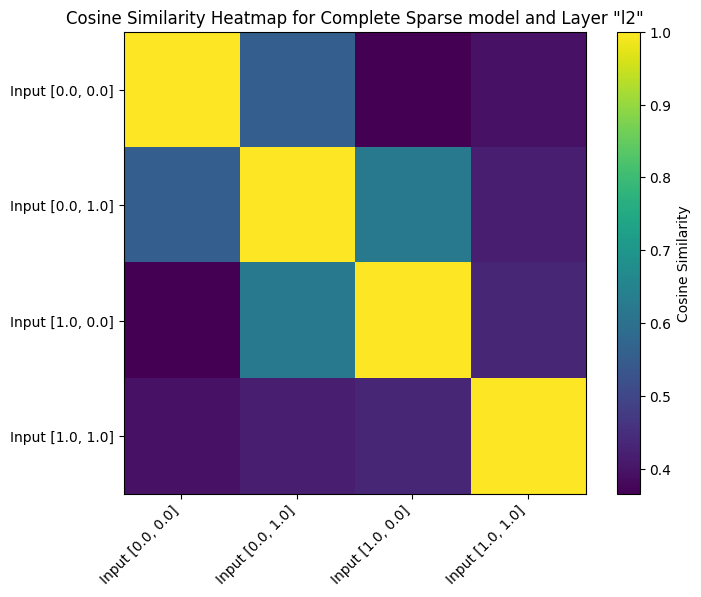

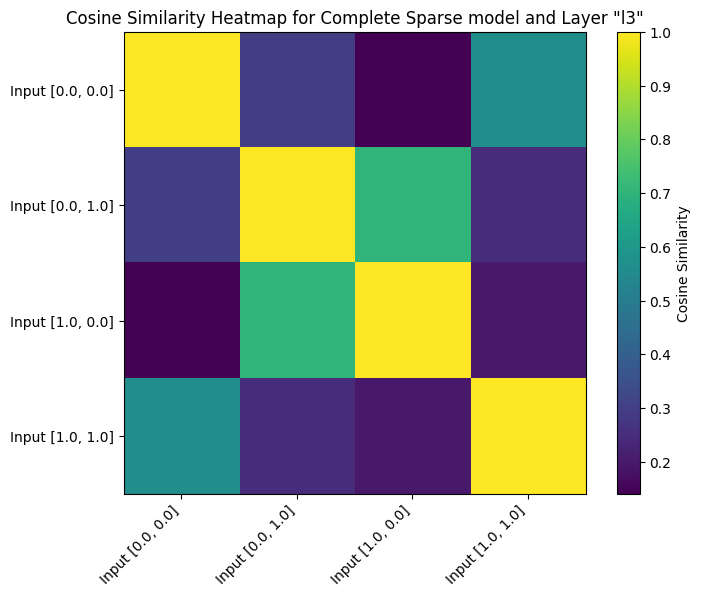

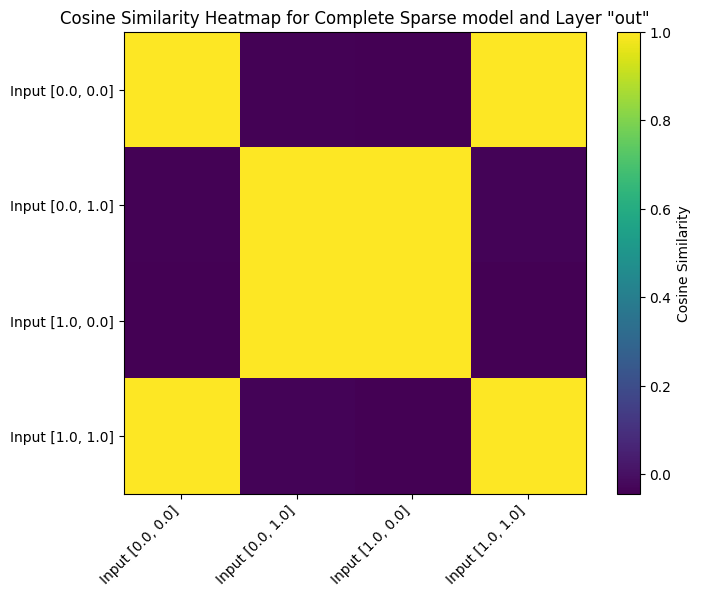

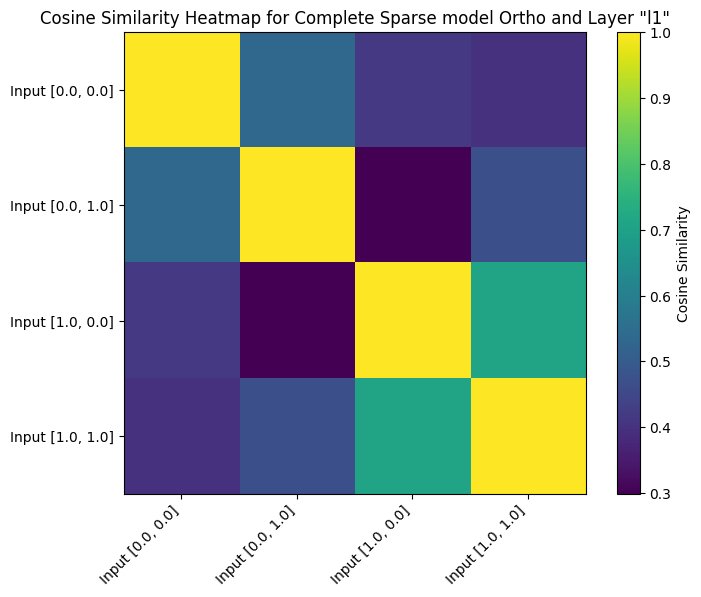

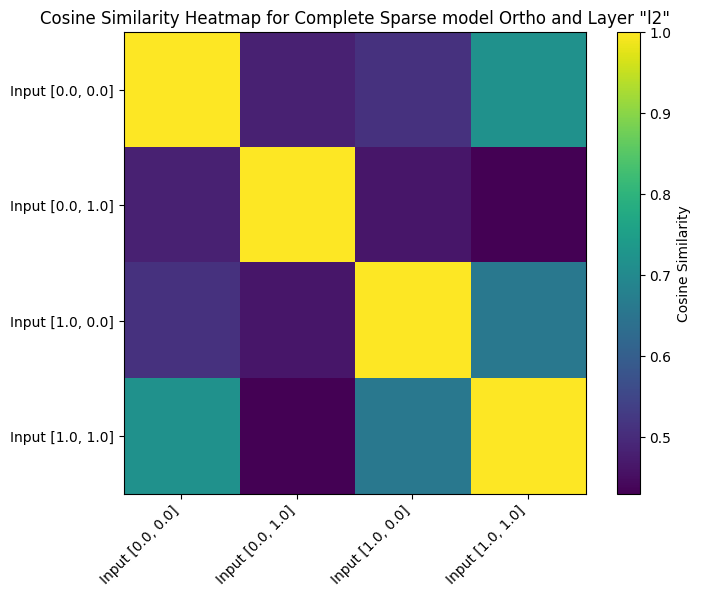

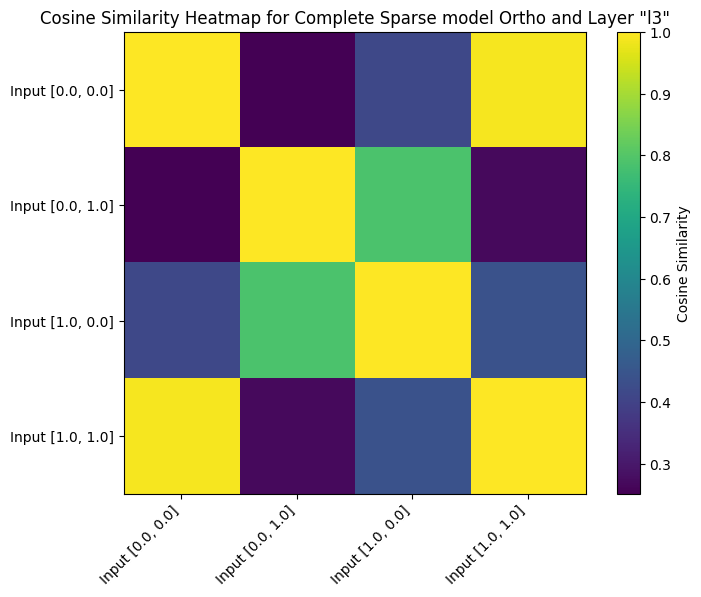

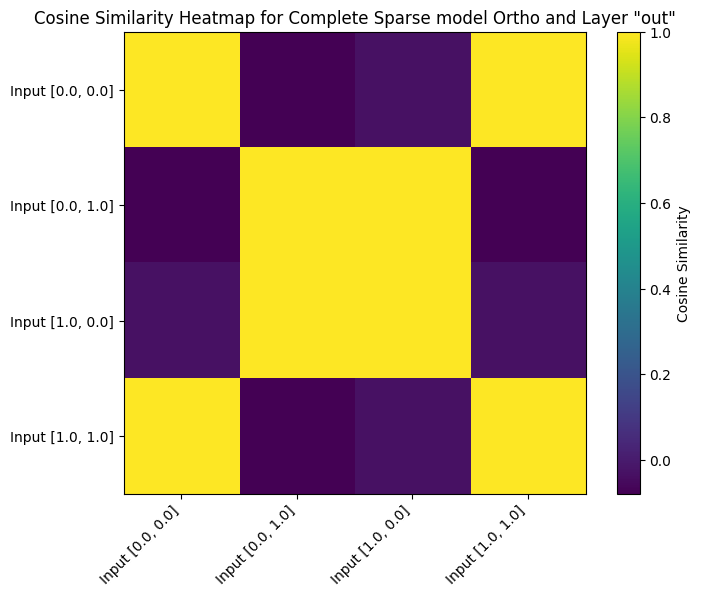

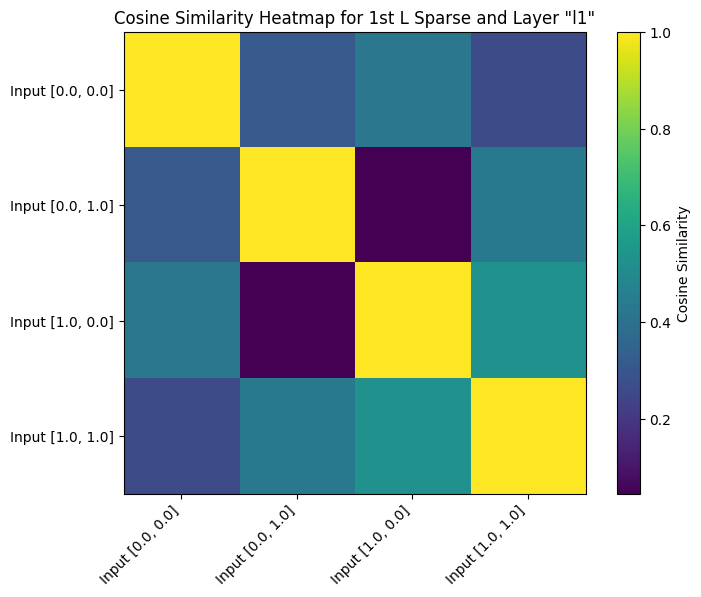

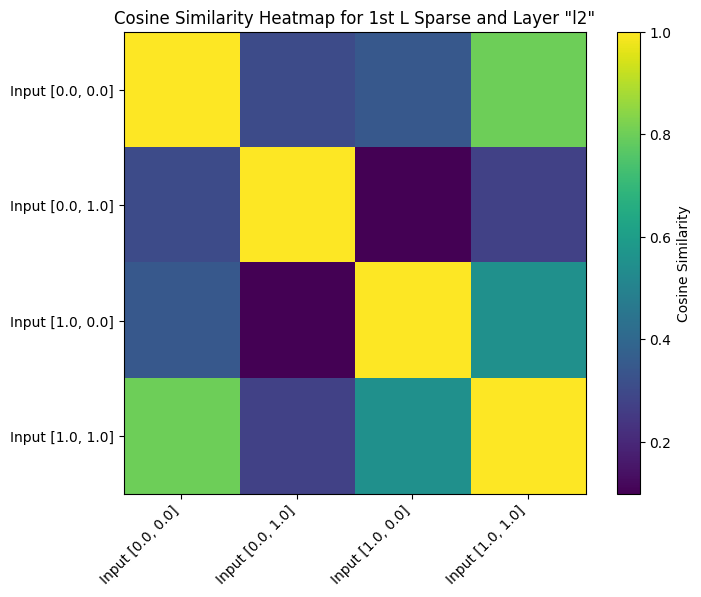

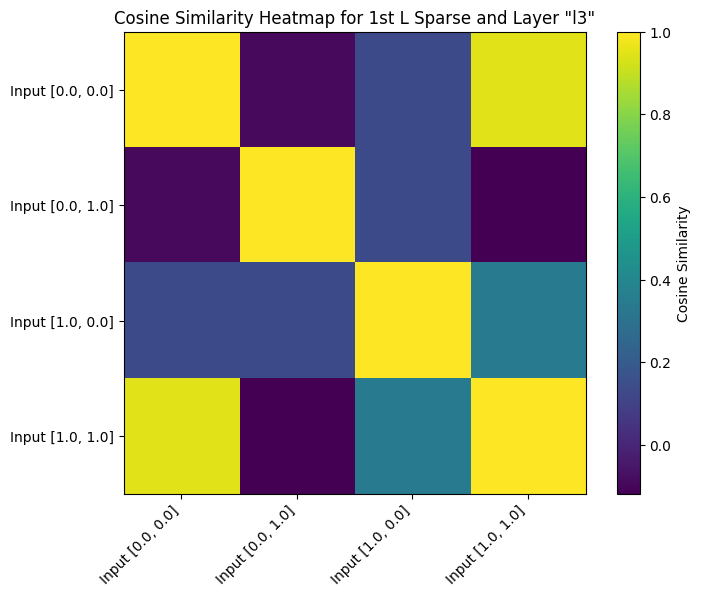

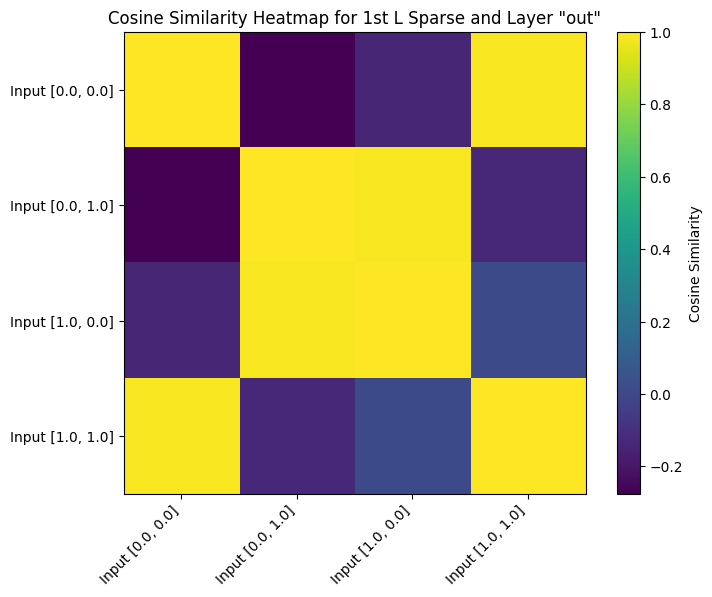

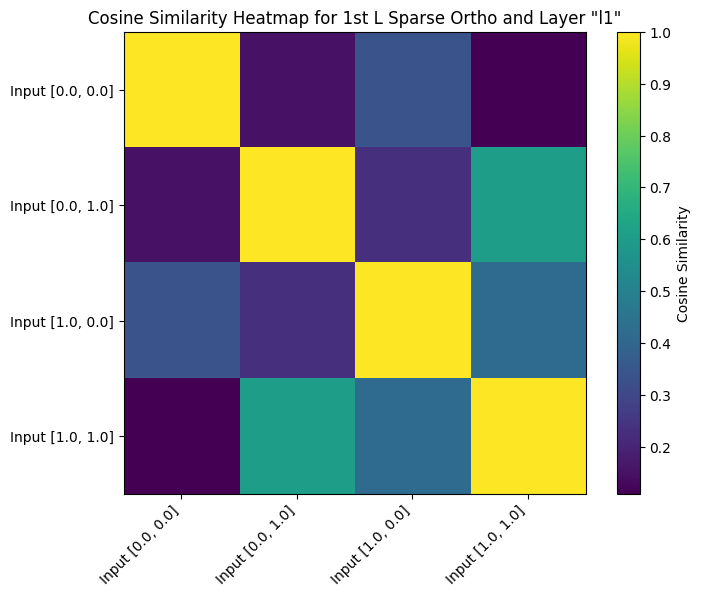

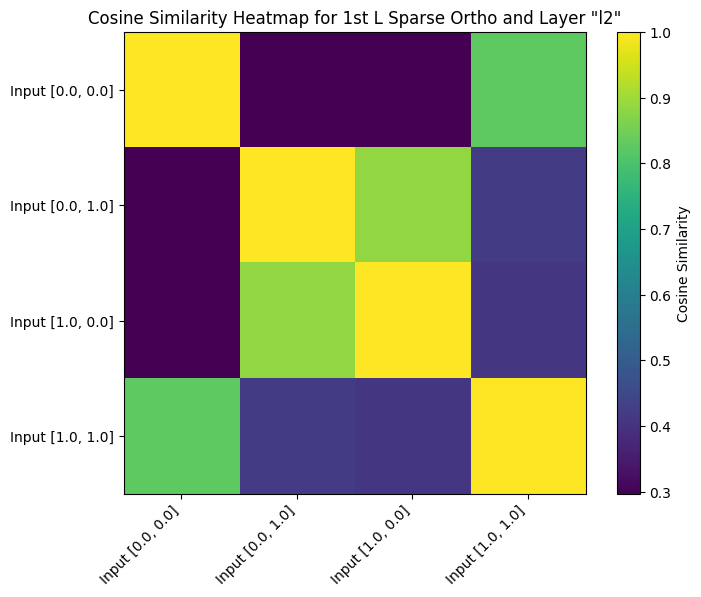

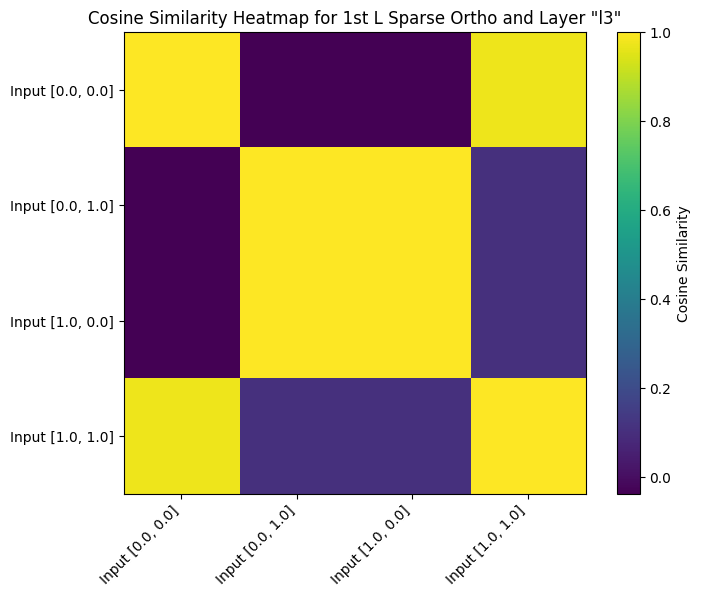

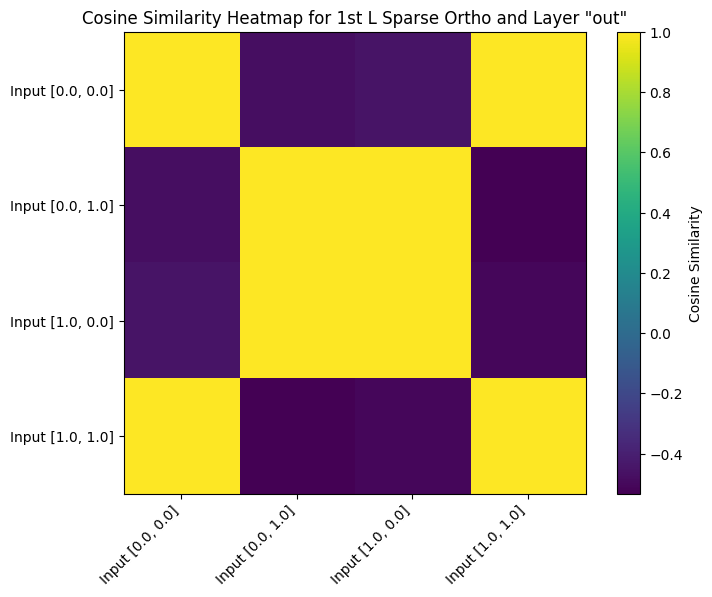

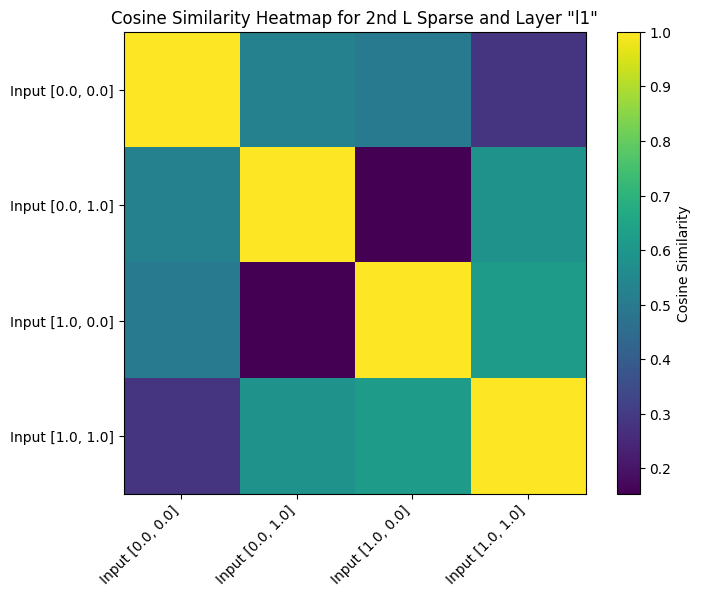

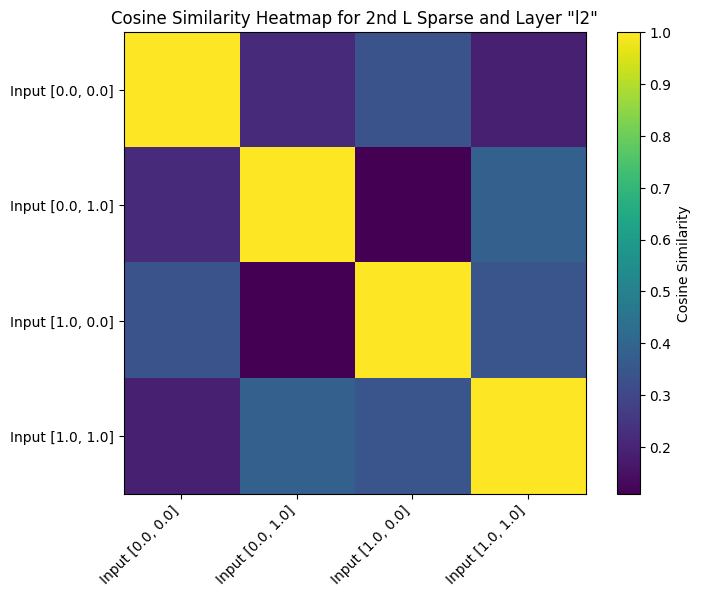

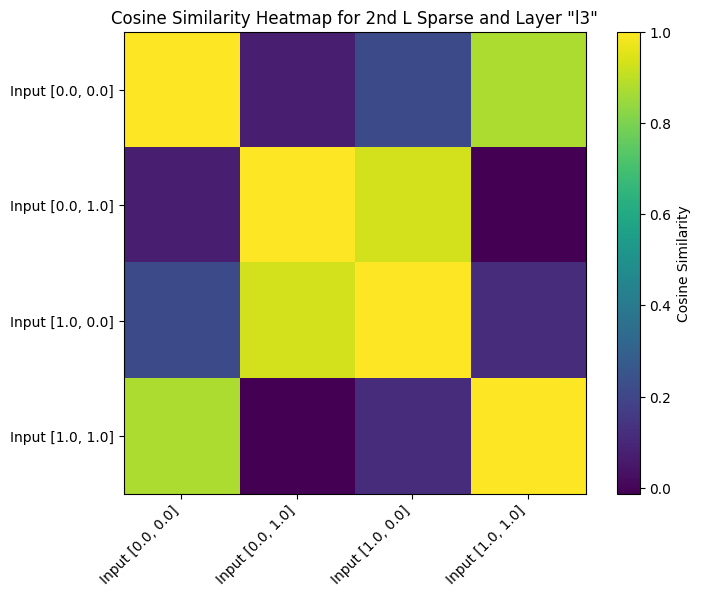

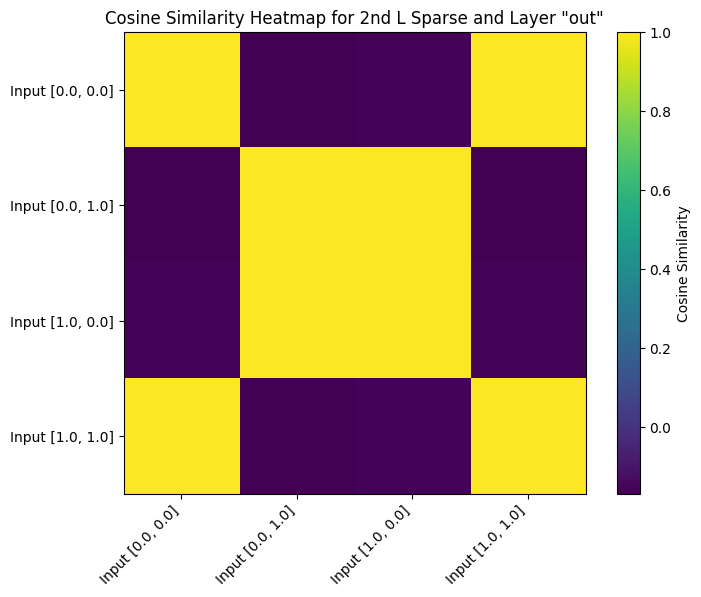

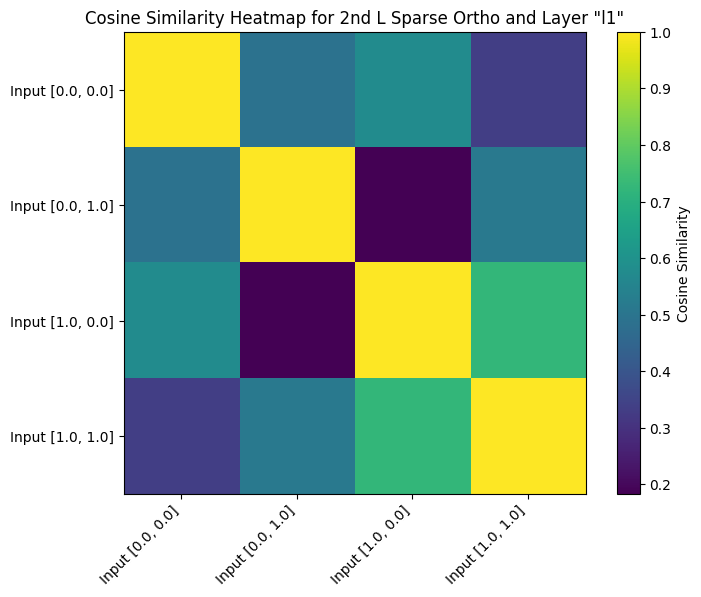

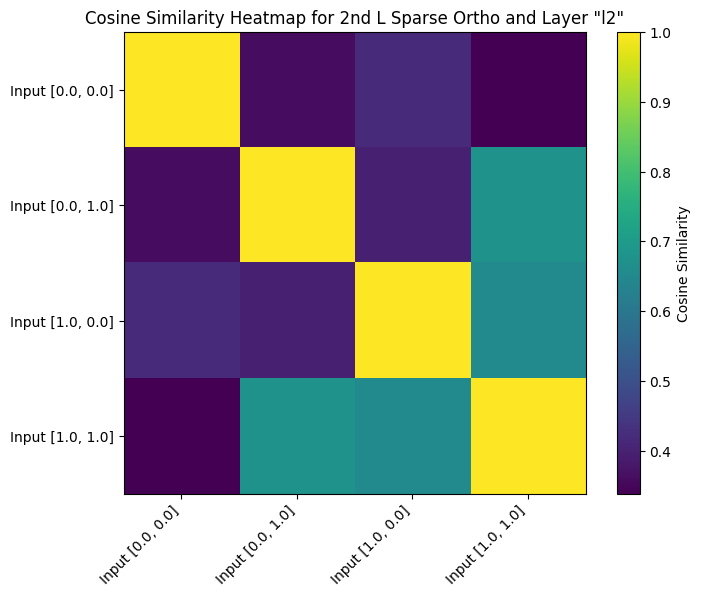

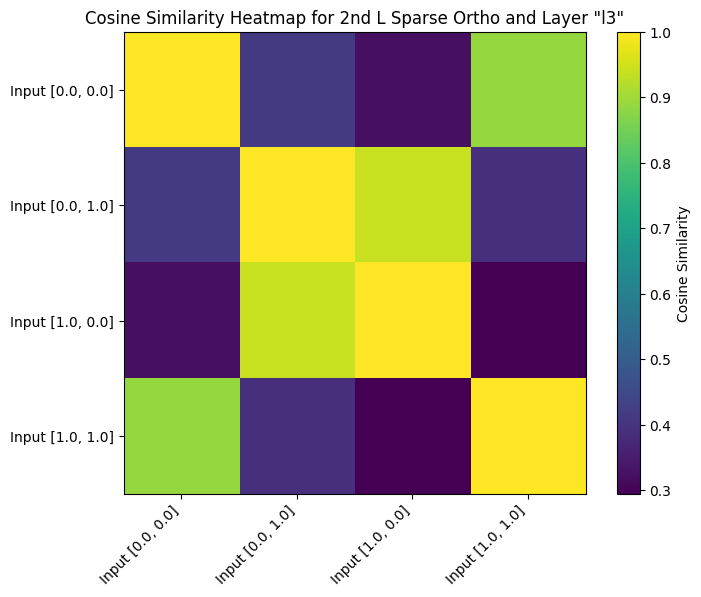

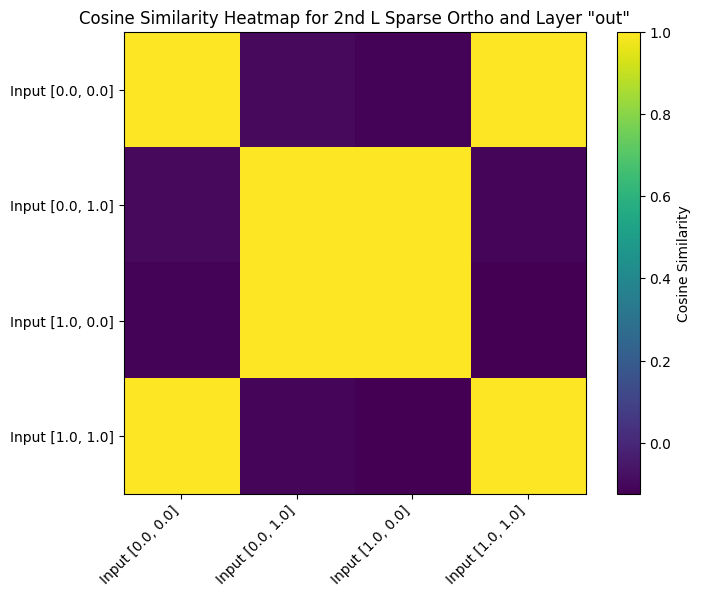

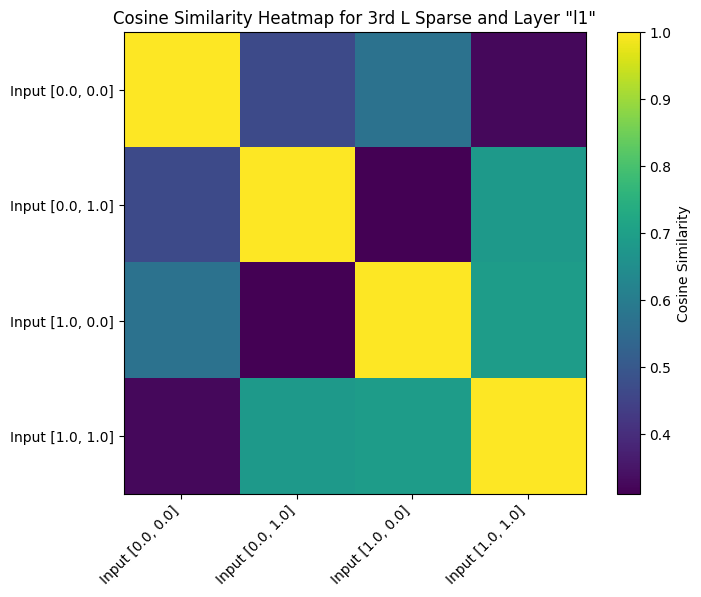

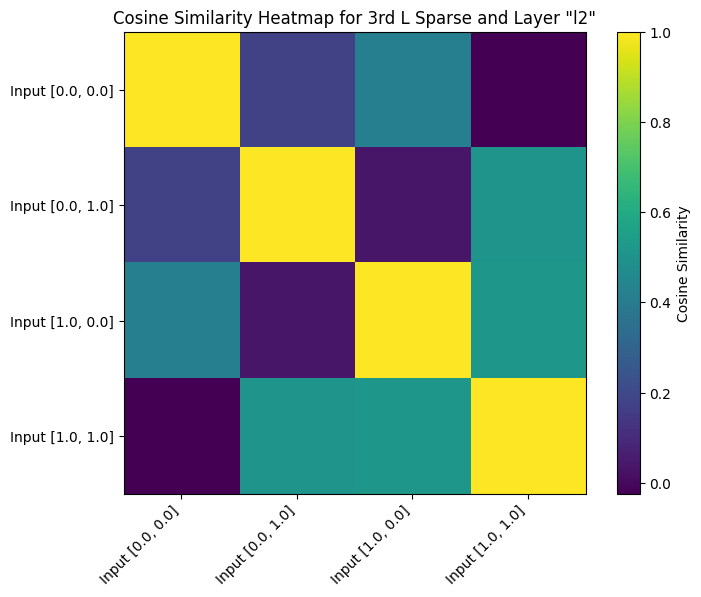

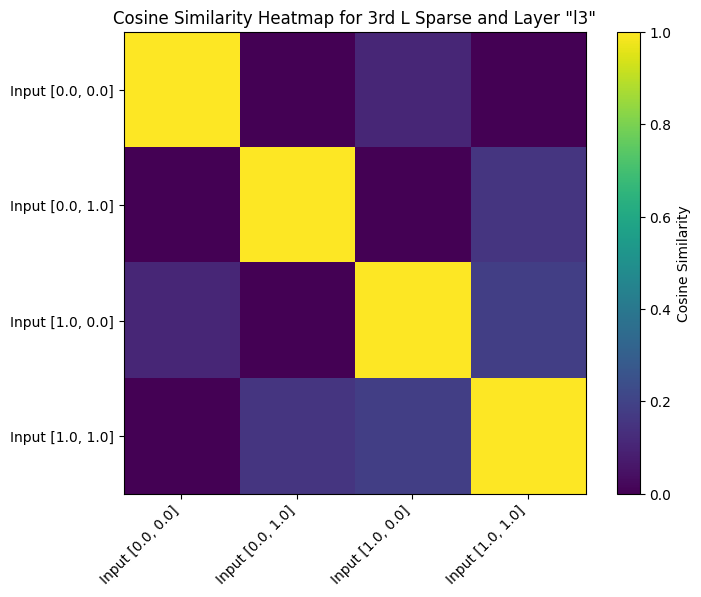

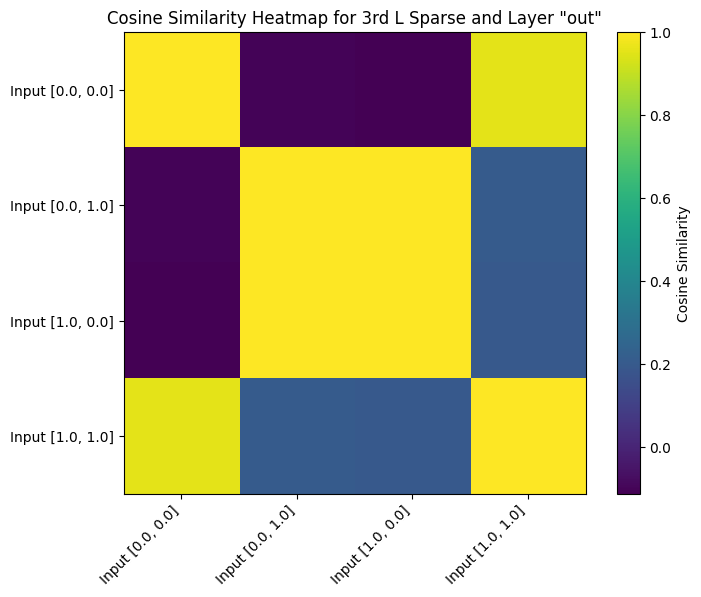

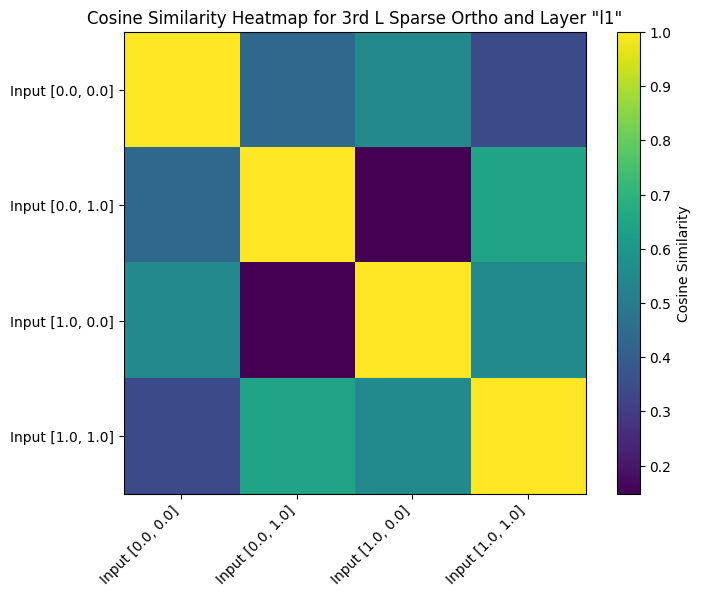

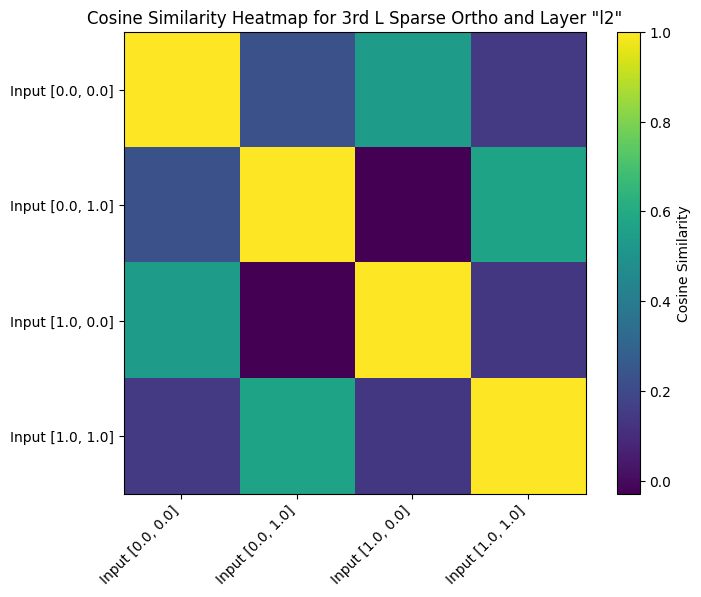

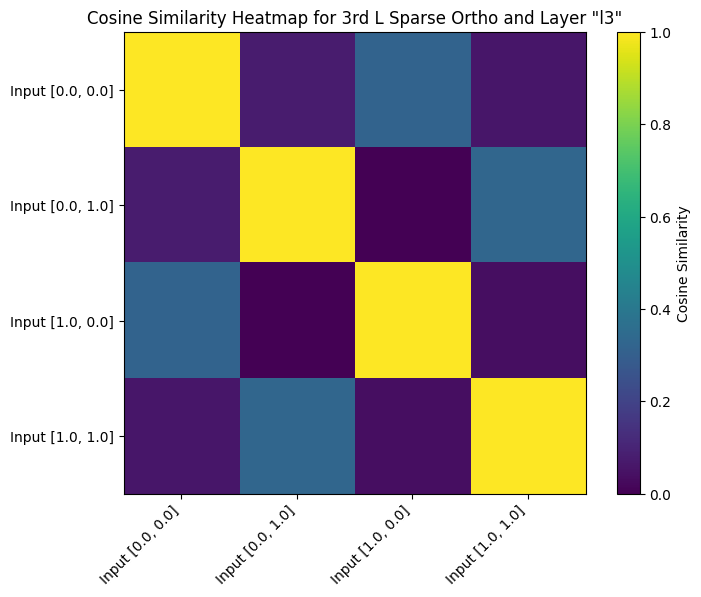

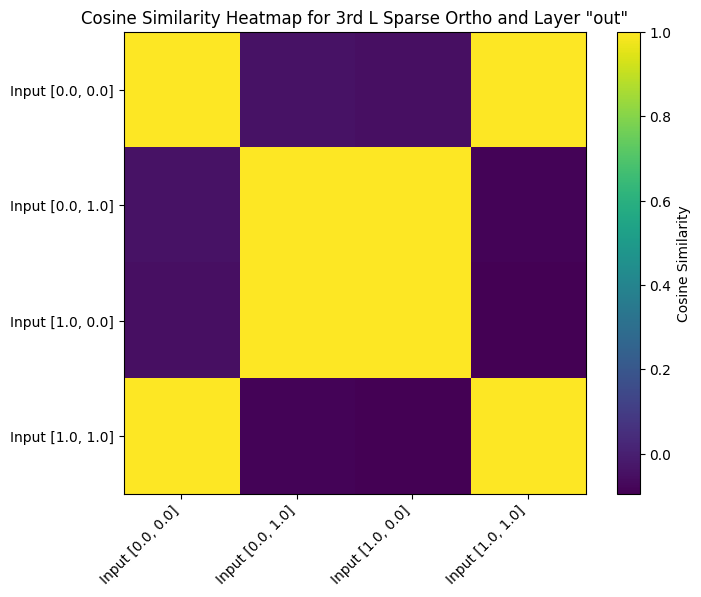

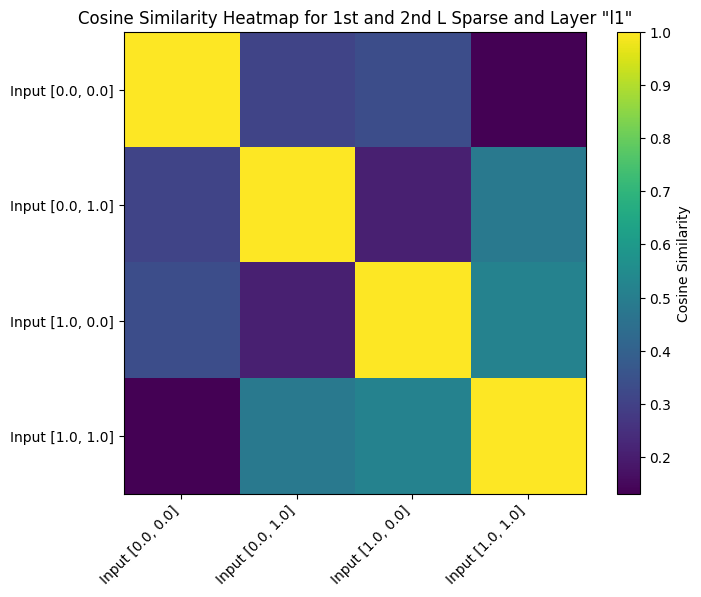

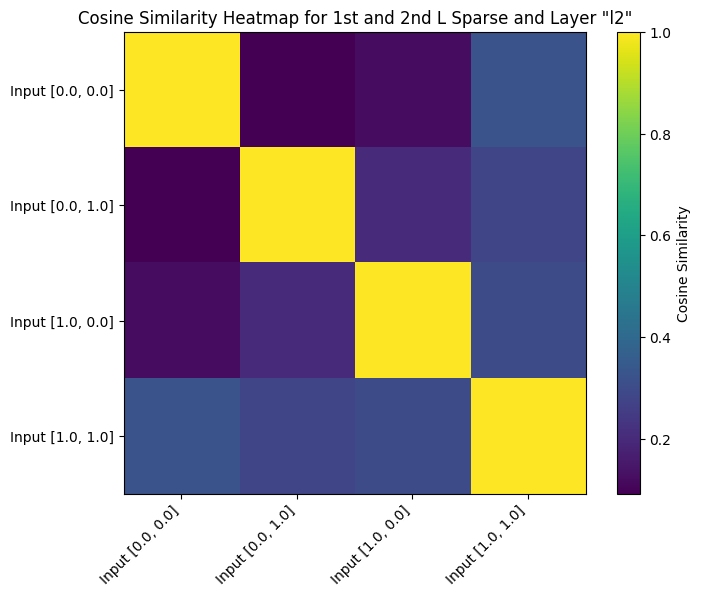

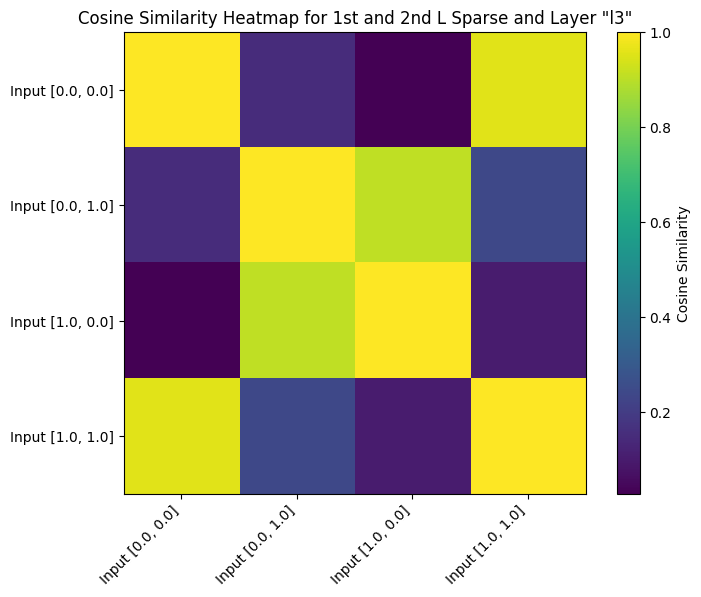

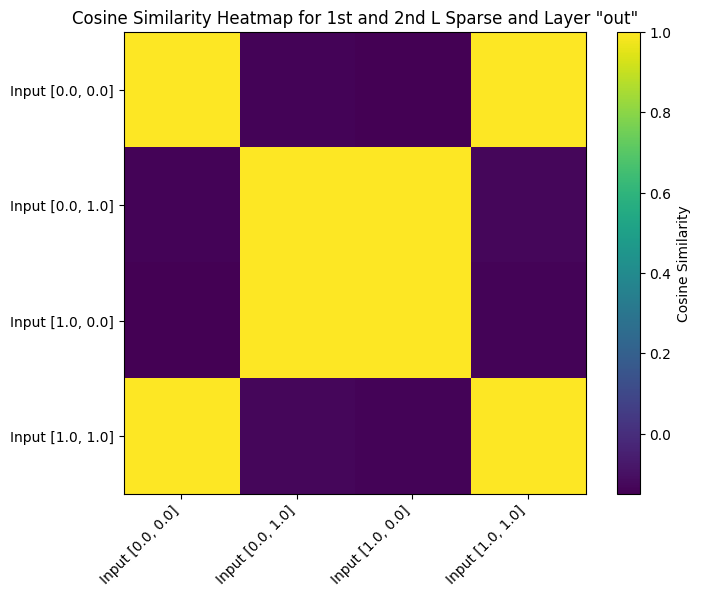

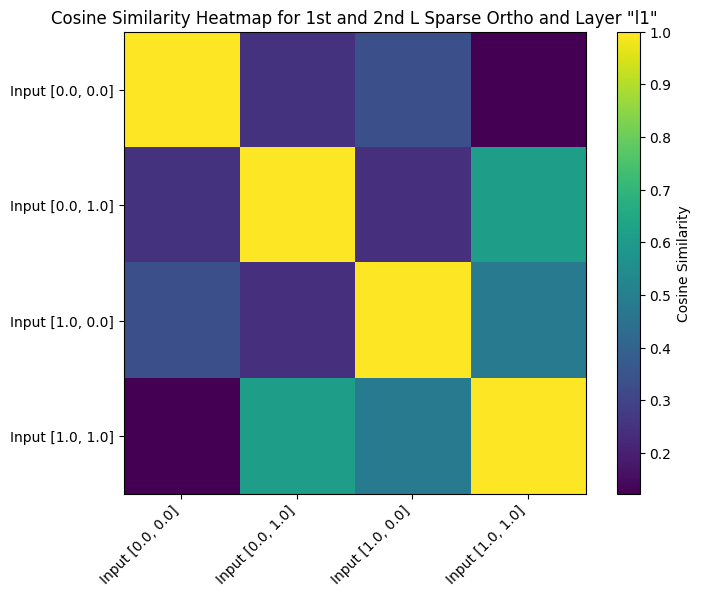

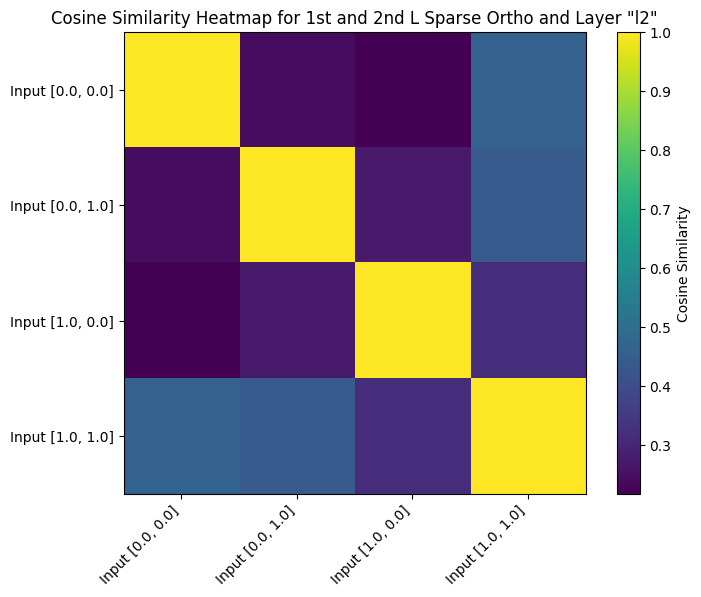

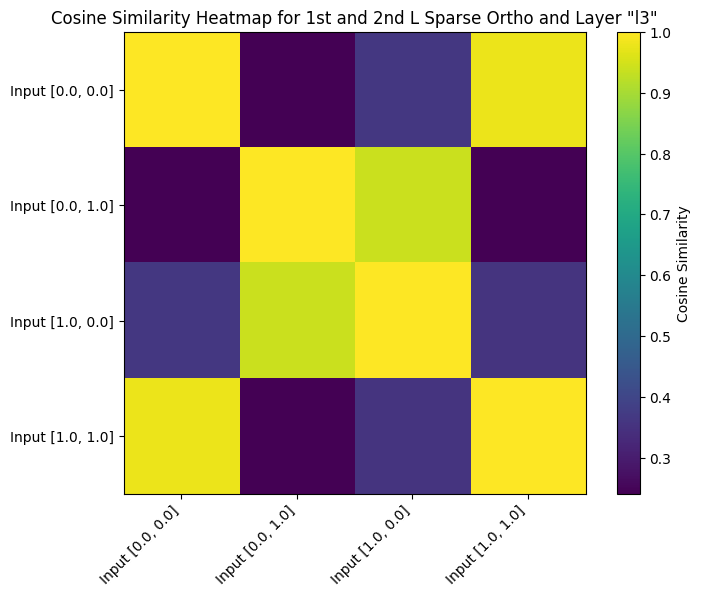

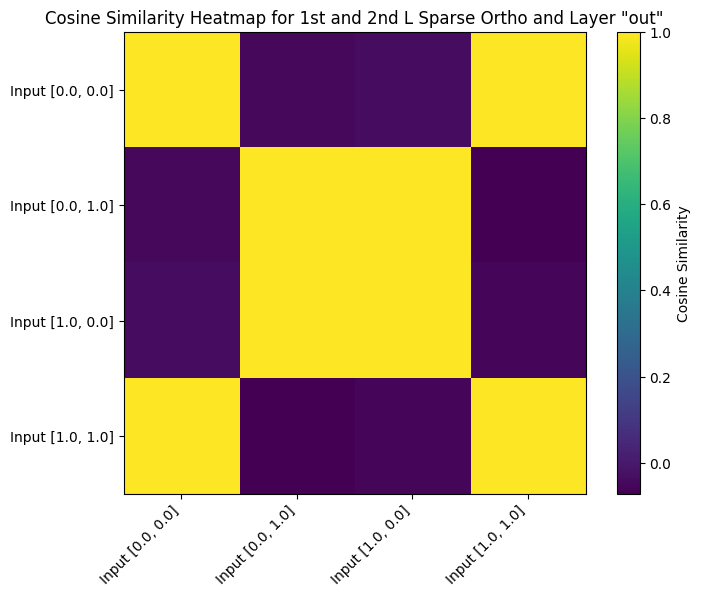

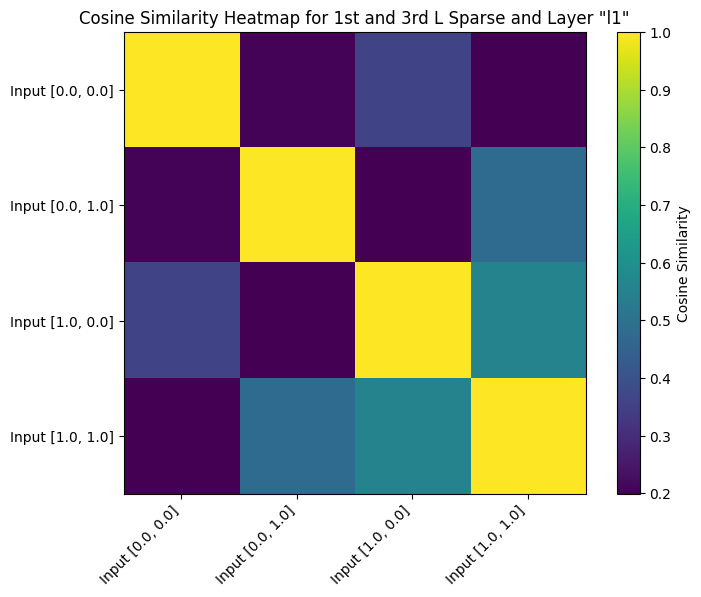

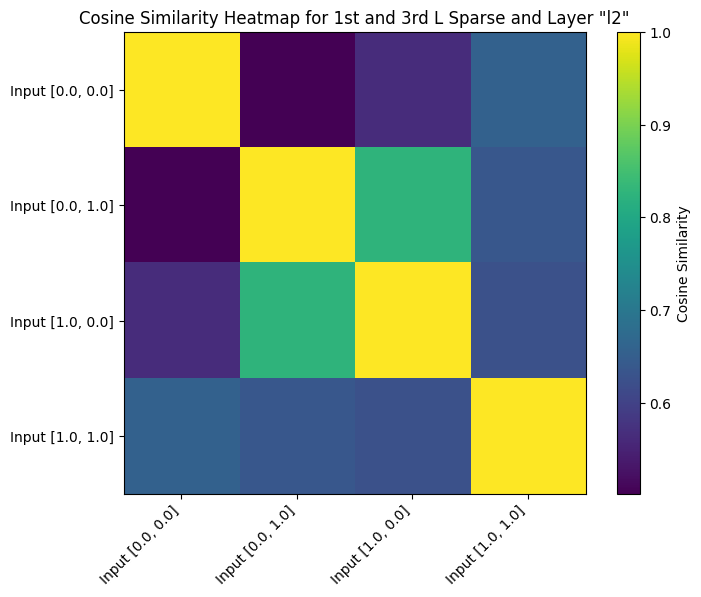

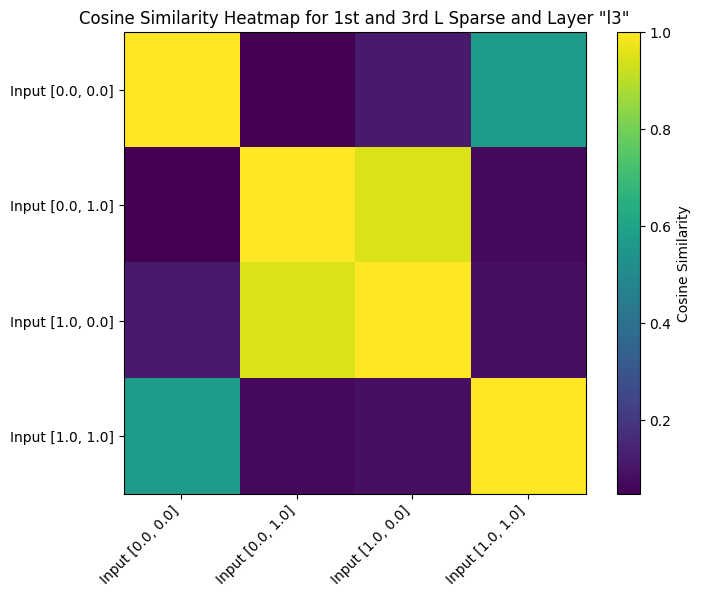

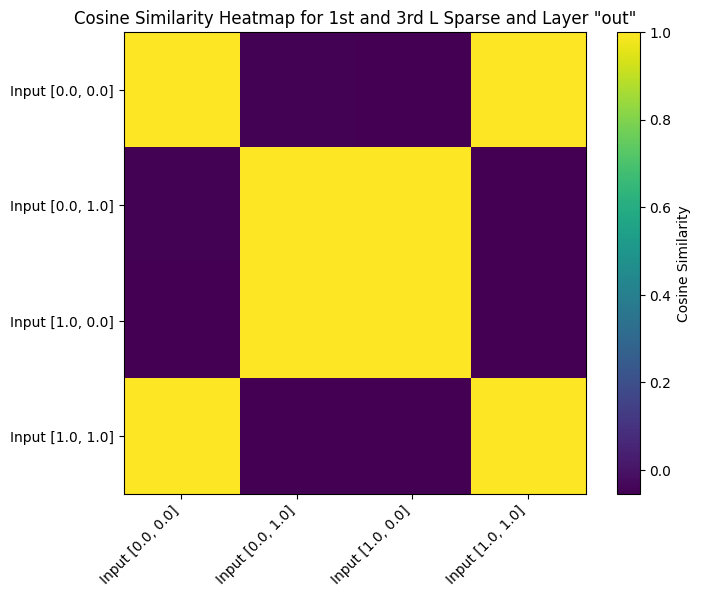

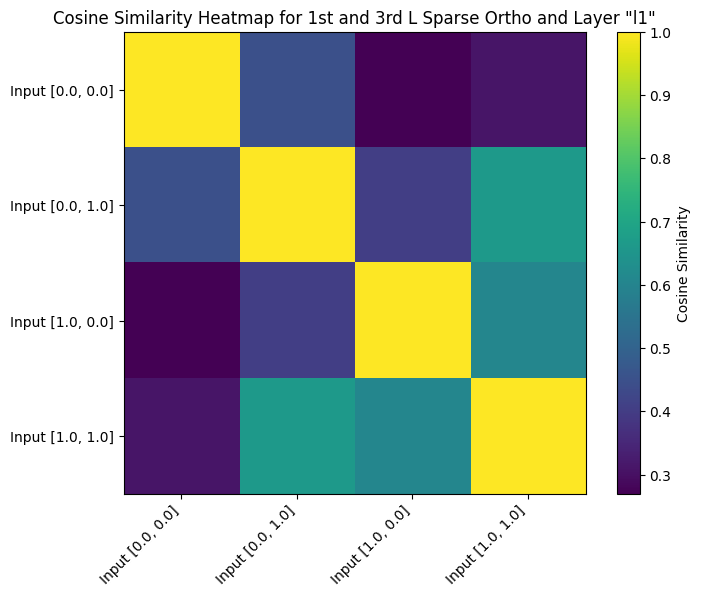

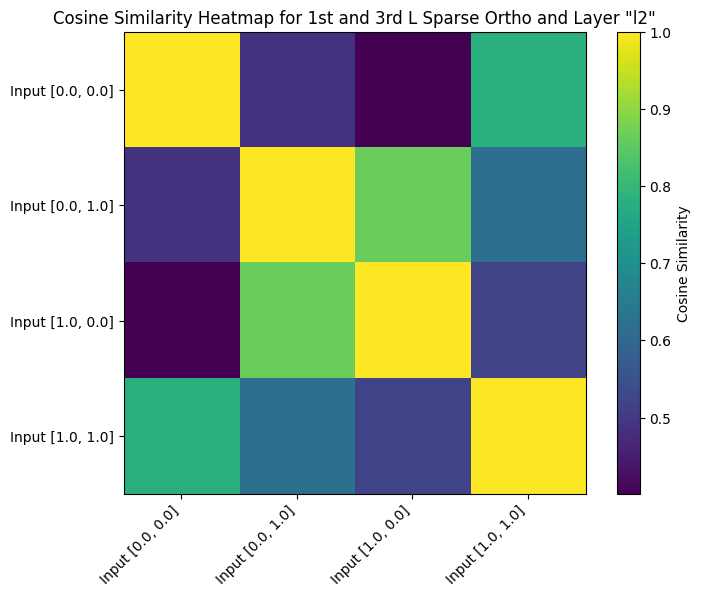

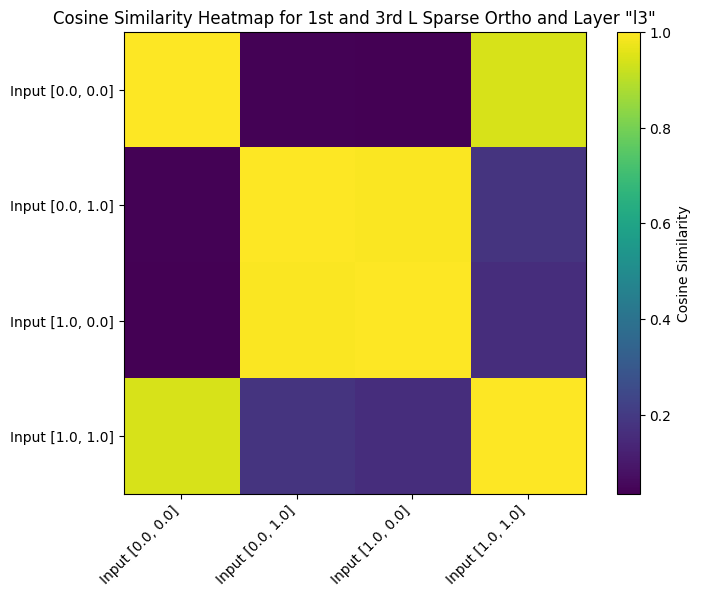

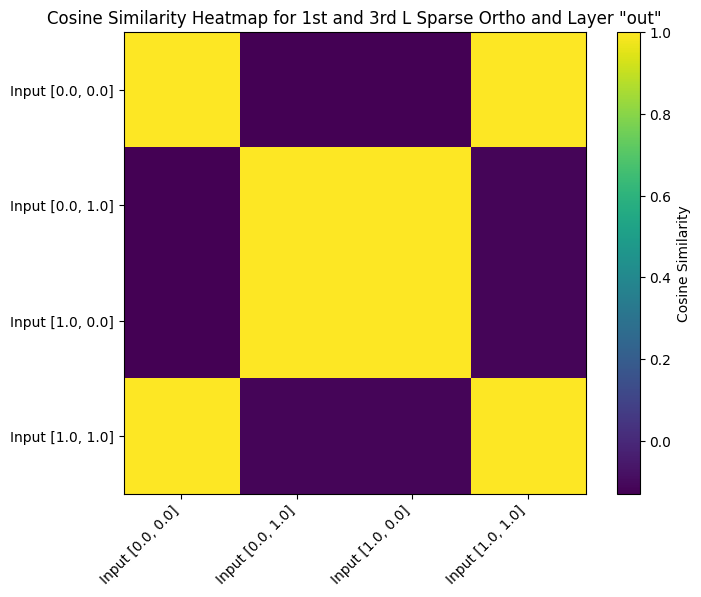

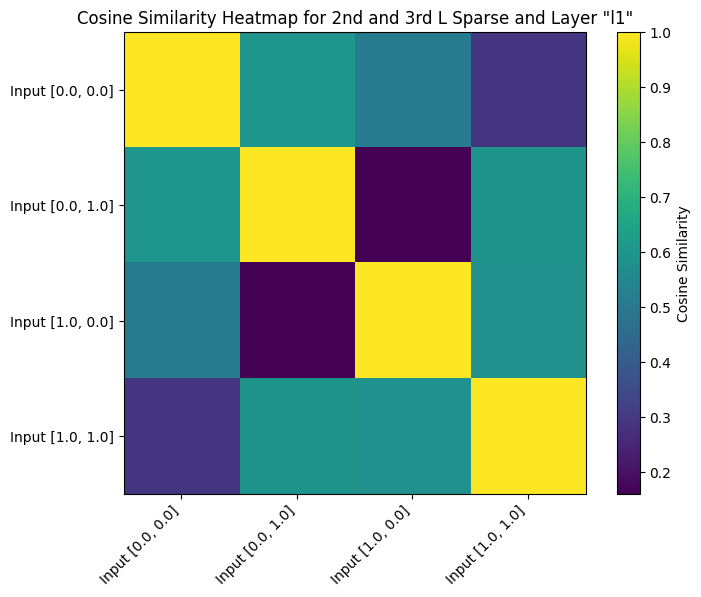

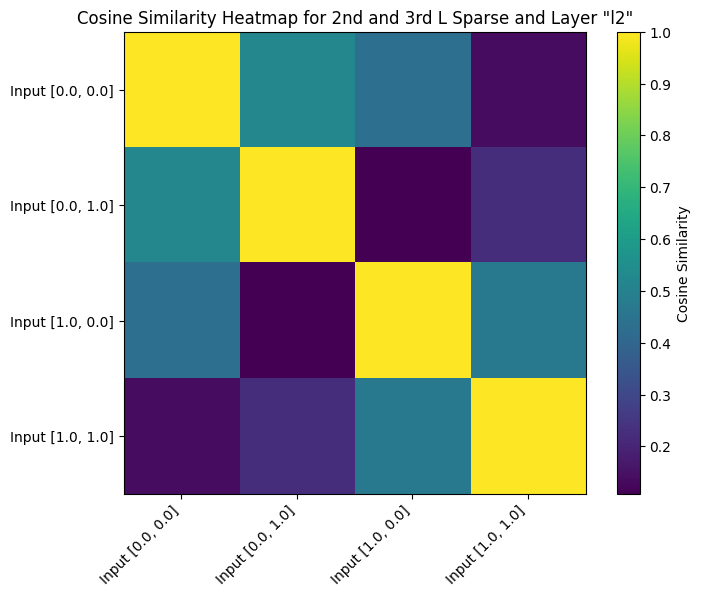

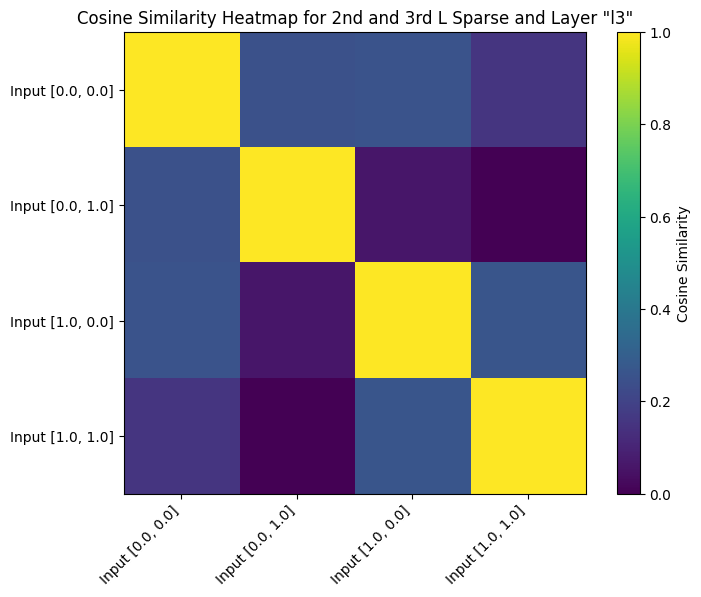

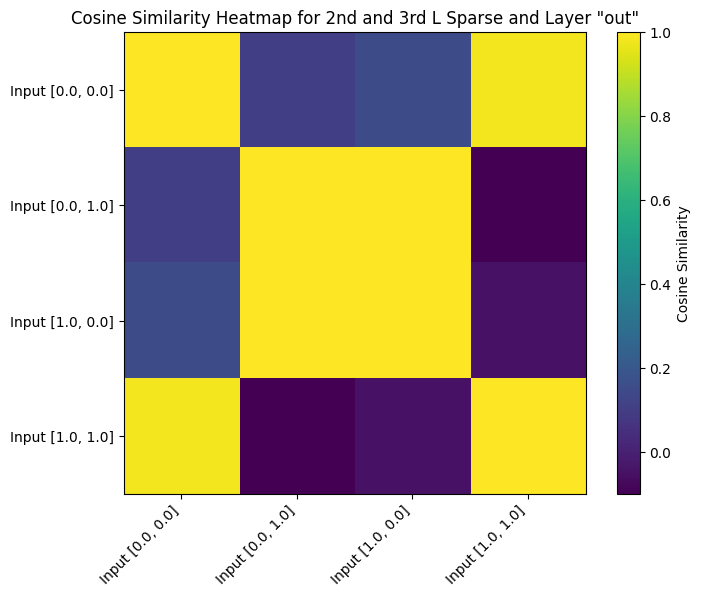

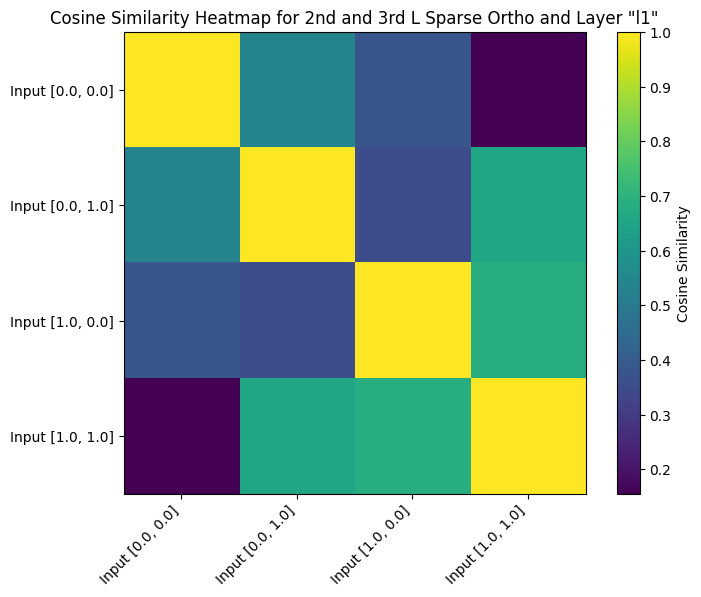

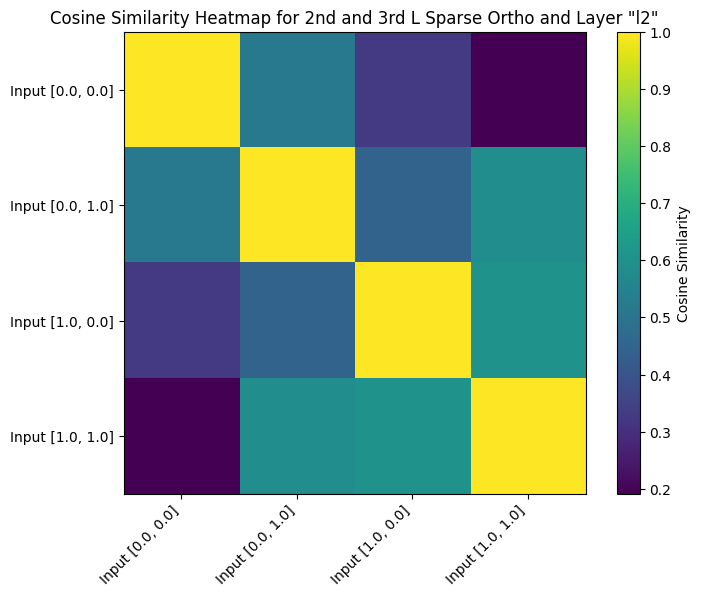

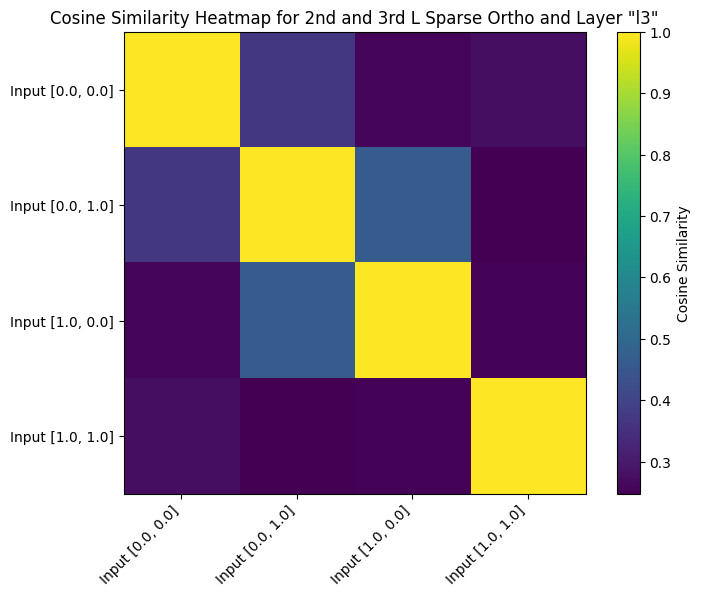

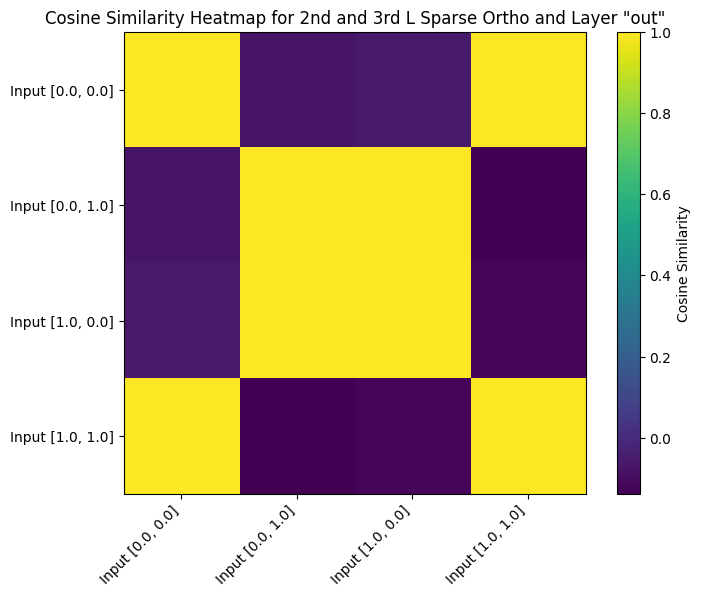

In [118]:
heatmap = {}
for modelName in sparseActivations:
    for layerName in layers:
        acts = sparseActivations[modelName][layerName]  # shape: (4, 250)

        # Compute cosine similarities
        # We'll compare each pair of the 4 activations
        num_inputs = acts.shape[0]
        if modelName not in heatmap.keys():
            heatmap[modelName] = {}
        heatmap[modelName][layerName] = get_similarity_plot(acts, modelName, layerName, num_inputs)

In [ ]:
for modelName in heatmap:
    for layer in heatmap[modelName]:
        # print("Creating heatmap for", modelName, "and layer", layer)
        heatmap[modelName][layer].imsh

dict_keys(['Control Model', 'Dense Model', 'Complete Sparse model', 'Complete Sparse model Ortho', '1st L Sparse', '1st L Sparse Ortho', '2nd L Sparse', '2nd L Sparse Ortho', '3rd L Sparse', '3rd L Sparse Ortho', '1st and 2nd L Sparse', '1st and 2nd L Sparse Ortho', '1st and 3rd L Sparse', '1st and 3rd L Sparse Ortho', '2nd and 3rd L Sparse', '2nd and 3rd L Sparse Ortho'])
dict_keys(['l1', 'l2', 'l3', 'out'])


In [104]:
fig = heatmap['Control Model']['l1']
plt.show()